# Improved method

SUM, GLOBAL and LOCAL are basic approaches, each of them with some drawbacks. There is the necessity to develop an improved one

#### GOAL
generate the initial SHORTEST and SAFEST path, which means:
- optimal travel time
- highest success-planning ratio

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
from skimage.morphology import binary_erosion, convex_hull_image, convex_hull_object
from matplotlib.colors import ListedColormap
import matplotlib.patches as pltpat
from scipy.ndimage import binary_dilation
import matplotlib.patches as mpatches

import math
import time
import random
from matplotlib import cm
from collections import deque

from geopy.distance import lonlat, distance

from Astar_netcdf import AStarPlanner
from rrtstar_netcdf import RRTStar
from rrt_netcdf import RRT
show_animation = False

In [3]:
data = xr.open_dataset('wave2021.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]
# 2021-07-18, 2021-08-23, 2021-08-24, 2021-09-10, 2021-09-18, 
# 2021-10-11, 2021-10-22, 2021-10-27, 2021-10-31, 2021-11-05, 2021-12-18, 2021-03-07
july18 = data.sel(time='2021-07-18') 
wave = july18.variables['VHM0'][:]

# data = xr.open_dataset('15161718april.nc')
# data = data.sel(time='2022-04-18') 
# lats = data.variables['latitude'][:]
# lons = data.variables['longitude'][:]
# times = data.variables['time'][:]
# wave = data.variables['VHM0'][:]

In [4]:
# general basemap of Italy configuration space
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58, 
             urcrnrlon=15.13, 
             urcrnrlat=45.5488,  
             resolution='i') # f

# lon, lat = np.meshgrid(lons, lats)   # 62 x 47
# x, y = mp(lon, lat)

# x_min, y_min = mp(lons.values[0], lats.values[0]) 
# x_max, y_max = mp(lons.values[-1], lats.values[-1])  

# print(x_min, x_max, y_min, y_max)

### Small map directly

In [7]:
mp2 = Basemap(projection='merc',
             llcrnrlon=lons.values[0],  
             llcrnrlat=lats.values[0], 
             urcrnrlon=lons.values[-1], 
             urcrnrlat=lats.values[-1],  
             resolution='i') # f

lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp2(lon, lat)

### Image height and width

In [8]:
# hh = 18000 / (distance(lonlat(*(6.42,40.58)), lonlat(*(6.42,45.5488))).m / mp(15.13,45.5488)[1])
# ww = 18000 / (distance(lonlat(*(6.42,40.58)), lonlat(*(15.13,40.58))).m / mp(15.13,45.5488)[0])

# for small map
hh = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[0],lats.values[-1]))).m / mp2(lons.values[-1],lats.values[-1])[1])
ww = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[-1],lats.values[0]))).m / mp2(lons.values[-1],lats.values[-1])[0])

print(f"image height: {hh}\nimage width: {ww}")

x_min, y_min = mp2(lons.values[0], lats.values[0]) 
x_max, y_max = mp2(lons.values[-1], lats.values[-1])  

image height: 24369.62094343742
image width: 23918.5304863459


In [9]:
## selective time-windows for different days
l = 24
li = 0   # 0   4(7-5)  4   3   2  -  5   11    0    0    3    6    3   
le = 15  # 15  18    18  17    15  - 17   23   12   12   15   18   15   
cost = np.zeros_like(wave[li:le])
contour_raw_meteo = np.zeros_like(wave[li:le])  # contour of each window (useless now)
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(le-li):
    cost[i] = 100 * (np.array(wave[i+li]) > 0.8)
    contour_raw_meteo[i]=np.logical_xor(cost[i],binary_erosion(cost[i]))

<ipython-input-10-09ff1d26fb06>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp2.pcolor(x, y, cost[k], cmap=ListedColormap(['white', 'red']), alpha=0.6)
<ipython-input-10-09ff1d26fb06>:6: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[k], linestyles='dashed', colors ='black', linewidths=2, levels=0)


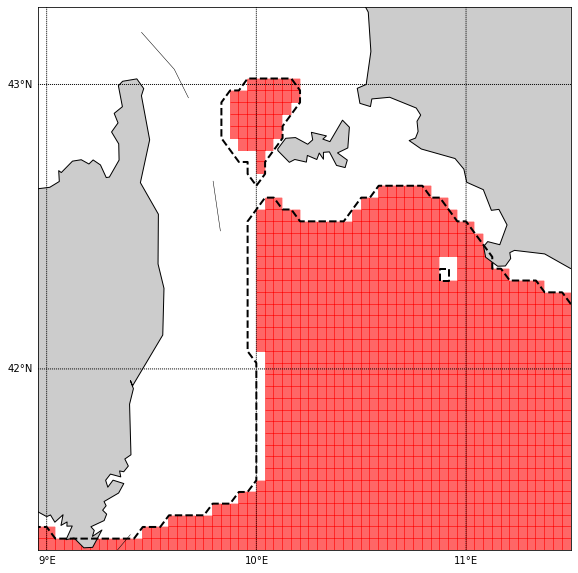

In [10]:
k=0
plt.figure(1, figsize=(15, 10))
mp2.pcolor(x, y, cost[k], cmap=ListedColormap(['white', 'red']), alpha=0.6)
# mp2.pcolor(x, y, dilate0[k], cmap=ListedColormap(['white', 'blue']), alpha=0.5)
# mp2.pcolor(x, y, dilate0[k], cmap=ListedColormap(['white', 'blue']), alpha=0.5)
plt.contour(x, y, cost[k], linestyles='dashed', colors ='black', linewidths=2, levels=0)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
mp2.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes

# plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# plt.title('Significant wave height $H_s$ on 22-11-2021 0:00 Ligurian Sea')
# plt.savefig("uncertainty0.png", dpi=300,bbox_inches='tight')
plt.show()

In [207]:
dilate0 = np.zeros_like(cost)
for i in range(le-li):
    dilate0 = binary_dilation(cost[i], iterations=1)
dilate0

# RRT*

In [11]:
try:
    from rrt_netcdf import RRT
except ImportError:
    raise

show_animation = False


class RRTStar(RRT):
    """
    Class for RRT Star planning
    """

    class Node(RRT.Node):
        def __init__(self, x, y):
            super().__init__(x, y)
            self.cost = 0.0  # taking into account the cost

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 c_spacex,
                 c_spacey,
                 k,
                 connect_circle_dist,
                 expand_dis,
                 speed,
                 path_resolution,
                 goal_sample_rate,
                 max_iter=3000,
                 # RRT* parameter: planning constant for the recomputing of the cost
                 search_until_max_iter=False):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]

        """
        super().__init__(start, goal, obstacle_list, rand_area, c_spacex, c_spacey, k, expand_dis, speed, path_resolution,
                         goal_sample_rate, max_iter)
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal[0], goal[1])
        self.search_until_max_iter = search_until_max_iter

    def planning(self, animation=True):
        """
        rrt star path planning

        animation: flag for animation on or off .
        """
        v = 0
        self.node_list = [self.start]
        for i in range(self.max_iter):
            # print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)  # nearest index
            near_node = self.node_list[nearest_ind]  # nearest node of the list to the rnd point just found
            new_node = self.steer(near_node, rnd, self.expand_dis)  # at each iter new node change of expand_dis

            # adding cost from the near node and random node
            temp1 = mp2(near_node.x, near_node.y, inverse=True)
            temp2 = mp2(new_node.x, new_node.y, inverse=True)
            new_node.cost = near_node.cost + distance(lonlat(*temp1), lonlat(*temp2)).m

            # new_node.cost = near_node.cost + math.hypot(new_node.x-near_node.x, new_node.y-near_node.y)
            if self.check_collision(new_node, self.obstacle_list[self.k-1]):
                near_inds = self.find_near_nodes(new_node)  # now we have the indexes of nodes near new_node
                node_with_updated_parent = self.choose_parent(new_node, near_inds)  # arguments: new node and indexes
                if node_with_updated_parent:
                    self.rewire(node_with_updated_parent, near_inds)
                    self.node_list.append(node_with_updated_parent)
                else:
                    self.node_list.append(new_node)
            # mp(new_node.x, new_node.y, inverse=True)

            """if new_node.cost/5 > 3600*self.k:  # comment if global planning
                self.k += 1"""

                # if self.k > 14:
                #    self.k = 14

            if animation:
                v = self.draw_graph(self.obstacle_list[self.k-1], v, rnd)

            if (not self.search_until_max_iter) and new_node:  # if reaches goal
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index), new_node.cost, i

        print("reached max iteration")

        last_index = self.search_best_goal_node()   # if I want to search until reached max iteration
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and the tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:  # in a for loop
            near_node = self.node_list[i]  # the near node is each of the list with the corresponding list
            t_node = self.steer(near_node, new_node)  # it finds the node attached to new_node and define parent near_n
            if t_node and self.check_collision(t_node, self.obstacle_list[self.k-1]):
                costs.append(self.calc_new_cost(near_node, new_node))  # the function calc the cost as a distance
            else:  # costs is a list
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]  # find the index of near node (in the ball) with min cost
        new_node = self.steer(self.node_list[min_ind], new_node)  # segment between the min cost node and new node
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        #  compute the distance of each node from the goal
        dist_to_goal_list = [self.calc_dist_to_goal(n.x, n.y) for n in self.node_list]
        #  if the distance if smaller than expand dis -> add the relative index to the goal_inds list
        goal_inds = [dist_to_goal_list.index(i) for i in dist_to_goal_list if i <= self.expand_dis]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(t_node, self.obstacle_list[self.k-1]):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        min_cost = min([self.node_list[i].cost for i in safe_goal_inds])
        for i in safe_goal_inds:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """
        1) defines a ball centered on new_node
        2) Returns all nodes of the tree that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt((math.log(nnode) / nnode))
        # if expand_dist exists, search vertices in a range no more than expand_dist
        # if hasattr(self, 'expand_dis'):
        #    r = max(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]  # compute distance of each node from the new_node
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds  # returns the index list of those points with a distance smaller than the ball radius

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            # calc the cost as distance from node with new parent and nodes in the ball
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(edge_node, self.obstacle_list[self.k-1])
            improved_cost = near_node.cost > edge_node.cost  # can be True or False

            if no_collision and improved_cost:  # if True change near node with edge node
                near_node.x = edge_node.x
                near_node.y = edge_node.y
                near_node.cost = edge_node.cost
                near_node.path_x = edge_node.path_x
                near_node.path_y = edge_node.path_y
                near_node.parent = edge_node.parent
                self.propagate_cost_to_leaves(new_node)

    def calc_new_cost(self, from_node, to_node):
        #d, _ = self.calc_distance_and_angle(from_node, to_node)
        temp1 = mp2(from_node.x, from_node.y, inverse=True)
        temp2 = mp2(to_node.x, to_node.y, inverse=True)
        d = distance(lonlat(*temp1), lonlat(*temp2)).m
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):  # a recursive way to compute the cost of the path till the start

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

In [48]:
def fig_with_intersection():
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    plt.plot(sx_init, sy_init, "<k", markersize=40)
    plt.plot(gx_a, gy_a, "Xr", markersize=20)
    for j in range(len(ellipse_interp)):
        plt.plot([x for (x, y) in ellipse_interp[j]], [y for (x, y) in ellipse_interp[j]], '.', color="orange", alpha=0.8)
    for i in range(le-li):
        ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                    color='red', alpha=0.7, fill = False))
    plt.plot([x for (x, y) in rrt_interp], [y for (x, y) in rrt_interp], '.k',label='interpolated points')
    for i in range(len(rx_rrt_finale)):
        if i == 0:
            plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20, label='approximated intersections path-temporal bands')
        else:
            plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20)
            
        if i == len(rx_rrt_finale)-1: # 15000, gy_a+5000, right,  6000, ry_rrt_finale[i]-1000
            plt.text(gx_a-15000, gy_a-10000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold', ha='left',va='bottom',color='k')
        else:
            plt.text(rx_rrt_finale[i]+6000, ry_rrt_finale[i]-1000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold',
                                ha='left',va='bottom',color='k')
    mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
    mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
    mp2.fillcontinents()
    mp2.drawcoastlines()
    mp2.drawstates()
    mp2.drawcountries()
    plt.show()

def fig_path():
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    plt.plot(sx_init, sy_init, "<k", markersize=40)
    plt.plot(gx_a, gy_a, "Xr", markersize=20)
    for i in range(len(obstacle_list_[0])):
        ax.add_patch(plt.Circle(xy=(obstacle_list_[0][i][0], obstacle_list_[0][i][1]), radius=4000,
                                color='b', alpha=0.3))
    for i in range(le-li):
        ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                    color='red', alpha=0.7, fill = False))
    plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-',label='RRT*')
    mp2.fillcontinents()
    mp2.drawcoastlines()
    mp2.drawstates()
    mp2.drawcountries()
    plt.show()
    
def fig_path_interp():
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    plt.plot(sx_init, sy_init, "<k", markersize=40)
    plt.plot(gx_a, gy_a, "Xr", markersize=20)
    for i in range(len(obstacle_list_[0])):
        ax.add_patch(plt.Circle(xy=(obstacle_list_[0][i][0], obstacle_list_[0][i][1]), radius=4000,
                                color='b', alpha=0.3))
    for i in range(le-li):
        ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                    color='red', alpha=0.7, fill = False))
    plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-',label='RRT*')
    plt.plot([x for (x, y) in rrt_interp], [y for (x, y) in rrt_interp], '.k',label='interpolated points')
    mp2.fillcontinents()
    mp2.drawcoastlines()
    mp2.drawstates()
    mp2.drawcountries()
    plt.show()  

In [437]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 15))
# plt.plot(sx_init, sy_init, ">k", markersize=40)
# plt.plot(gx_a, gy_a, "Xr", markersize=20)
# for j in range(len(ellipse_interp)):
#     plt.plot([x for (x, y) in ellipse_interp[j]], [y for (x, y) in ellipse_interp[j]], '.', color="orange", alpha=0.8)
# r = 34
# plt.plot(ellipse_interp[0][r][0], ellipse_interp[0][r][1], '.', markersize=30)
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
#                                 color='red', alpha=0.7, fill = False))
# mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
# mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
# mp2.fillcontinents()
# mp2.drawcoastlines()
# mp2.drawstates()
# mp2.drawcountries()
# plt.show()

In [49]:
xspace = lons.values
yspace = lats.values
sx = xspace[12]  
sy = yspace[7] 
gx = xspace[50]   # 50  39
gy = yspace[28]   # 28  33
sx_init, sy_init = mp2(sx, sy)

gx_a, gy_a = mp2(gx, gy)
grid_size = 4500 #  
# local classico
intern_x, intern_y = [], []    # list of image points of local obstacles
contint_x, contint_y = [], []  # list of contour points of local obstacles
x_obsl, y_obsl = [], []        # list of land static obstacles
Cspacex, Cspacey = [], []
image = np.zeros((47, 62))

for i in range(le-li):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if cost[i][k][j] == 100:
#                 oxmeteo[i].append(lons.values[j])
#                 oymeteo[i].append(lats.values[k])
                geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(sx,sy))).km
                if 18*(i) < geo_dist < 18*(i+1):
                    intern_x.append(lons.values[j])
                    intern_y.append(lats.values[k]) 
                    image[k][j] = 1
intern_x_, intern_y_ = mp2(intern_x, intern_y) 
# image = binary_dilation(image, iterations=1)

astar_contour = np.logical_xor(image,binary_erosion(image)) 
for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if astar_contour[k][j]:
                contint_x.append(lons.values[j])
                contint_y.append(lats.values[k]) 
contint_x_, contint_y_ = mp2(contint_x, contint_y)       # map contour points    

for k in np.arange(0,380,1):
    for j in np.arange(0,1307,1):
        if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
            if contour_raw_land[k][j]: 
                if lons_mask.values[j] > 9.8 and lats_mask.values[k]> 42:
                    x_obsl.append(lons_mask.values[j])
                    y_obsl.append(lats_mask.values[k])
            if mask.values[k][j] == 1:
                Cspacex.append(lons_mask.values[j])
                Cspacey.append(lats_mask.values[k])

Cspacex_, Cspacey_ = mp2(Cspacex, Cspacey)                   
x_obsl_, y_obsl_ = mp2(x_obsl, y_obsl)  

In [50]:
obstacle_list_ = [[] for i in range(2)]
for i in range(2): # just not to modify the algorithm of RRT*
    for j, _ in enumerate(contint_x_):
        obstacle_list_[i].append([contint_x_[j], contint_y_[j], grid_size])
    for j, _ in enumerate(x_obsl_):
        obstacle_list_[i].append([x_obsl_[j], y_obsl_[j], grid_size])   

In [51]:
rrt_star = RRTStar(
            start=[sx_init, sy_init],
            goal=[gx_a, gy_a],
            rand_area=[x_min, x_max, y_min, y_max],
            obstacle_list=obstacle_list_,
            c_spacex = Cspacex_,
            c_spacey = Cspacey_,
            k = 1,
            speed = 5,
            path_resolution=4500.0,
            connect_circle_dist=150000,
            goal_sample_rate=15,
            expand_dis=4500)

In [52]:
#%matplotlib
start_time = time.time()
path_star, cost_tot, iter_tot = rrt_star.planning(animation=show_animation)
path_star = list(reversed(path_star))
end_time = time.time()
if path_star is None:
    print("Cannot find path")
else:
    print("Found path!!")

print("The computational time is " + str(round(end_time - start_time, 4)) + " seconds")
# print("Travel time = ", str(round(cost_tot/5/3600,4)), "hours")

p = np.zeros_like(path_star)
for i in range(len(path_star)):
    p[i][0], p[i][1]  = mp2(path_star[i][0], path_star[i][1], inverse=True)

path_dist = 0
for i in range(len(p)-1):
    path_dist += distance(lonlat(*(p[i][0],p[i][1])), lonlat(*(p[i+1][0],p[i+1][1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Found path!!
The computational time is 5.6337 seconds
Travel time =  9.6799 hours


In [24]:
rrtloc50_geo = [np.zeros_like(locbandrrt50[i]) for i in range(12)]
# rrtloc39_geo = [np.zeros_like(locbandrrt39[i]) for i in range(12)]
for i in range(len(locbandrrt50)):
    if locbandrrt50[i] is not None:
        for j in range(len(locbandrrt50[i])):
            rrtloc50_geo[i][j][0], rrtloc50_geo[i][j][1]  = mp(locbandrrt50[i][j][0], locbandrrt50[i][j][1], inverse=True)
            rrtloc50_geo[i][j][0], rrtloc50_geo[i][j][1]  = mp2(rrtloc50_geo[i][j][0], rrtloc50_geo[i][j][1]) 

In [748]:
locpatha50_mp2 = [np.zeros_like(locpatha50[i]) for i in range(12)]
locpatha39_mp2 = [np.zeros_like(locpatha39[i]) for i in range(12)]
for i in range(len(locpatha39)):
    for j in range(len(locpatha39[i][0])):
        locpatha39_mp2[i][0][j], locpatha39_mp2[i][1][j]  = mp2(locpatha39[i][0][j], locpatha39[i][1][j])

In [749]:
locapf50_mp2 = [np.zeros_like(locapf50[i]) for i in range(12)]
locapf39_mp2 = [np.zeros_like(locapf39[i]) for i in range(12)]
for i in range(len(locapf39)):
    try:
        for j in range(len(locapf50[i])):
            locapf39_mp2[i][j][0], locapf39_mp2[i][j][1]  = mp2(locapf39[i][j][0], locapf39[i][j][1])
    except:
        continue
x_50_4 = improvedrrt50[4]


In [76]:
band_impr_loc3 = np.zeros((47, 62))
# band_impr_loc3 = band_map[5][7] #+ band_map[5][6] + band_map[5][7]
band_impr_loc3 += corrected_image2 + band_map[10][10]
band_impr_loc3 = 100*(np.array(band_impr_loc3)>=1)

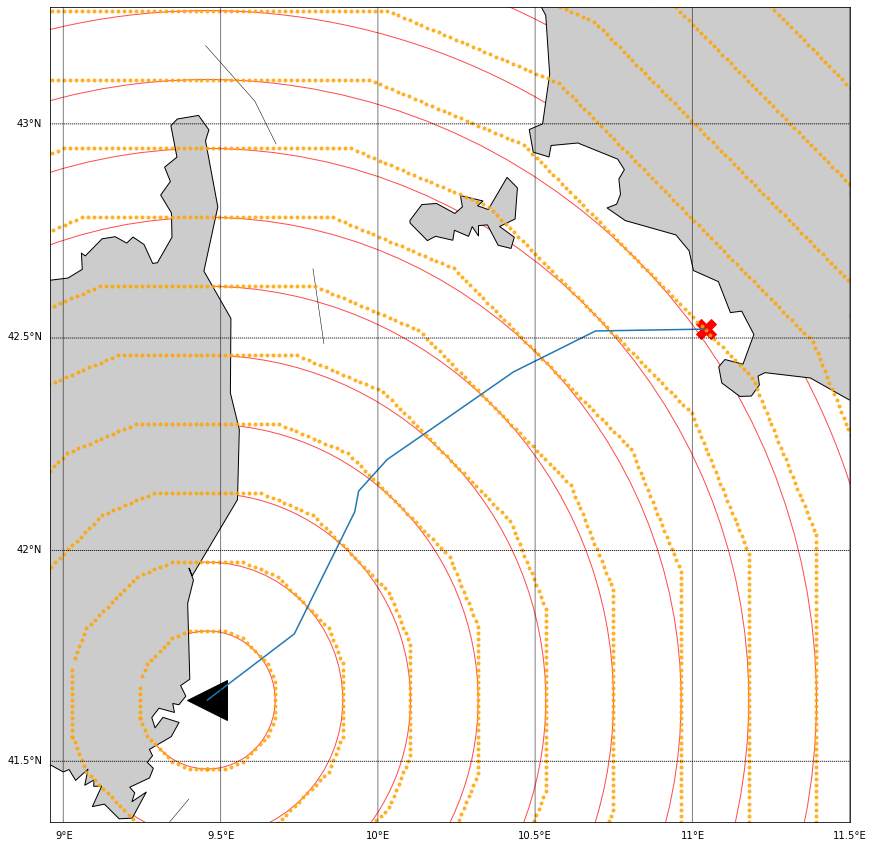

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.plot(sx_init, sy_init, "<k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.7, fill = False))
for j in range(len(ellipse_interp)):
    plt.plot([x for (x, y) in ellipse_interp[j]], [y for (x, y) in ellipse_interp[j]], '.', color="orange", alpha=0.8)
# plt.plot([x for (x, y) in rrtloc50_geo[4]], [y for (x, y) in rrtloc50_geo[4]], '-', label="rrt")
plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-')
# plt.plot([x for (x, y) in rrt_interp], [y for (x, y) in rrt_interp], '.k',label='Oversampled path points')
# impr1_patch = mpatches.Patch(color='#a55884', label='Unsafe zone with \nImproved method iter 1')
# loc_patch = mpatches.Patch(color='#ff8484', label='Unsafe zone with \nImproved method iter 2')

#a55884
# for i in range(len(rx_rrt_finale)):
#     if i == 0:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20, label='Approximated intersections\npath-temporal bands')
#         plt.text(rx_rrt_finale[i]-10000, ry_rrt_finale[i]+5000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold',
#                             ha='left',va='bottom',color='k')
#     elif i == len(rx_rrt_finale)-1:
#         pass
#     elif i == 1:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20)
#         plt.text(rx_rrt_finale[i]-14000, ry_rrt_finale[i]+3000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold',
#                             ha='left',va='bottom',color='k')
#     else:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20)
# #     if i == len(rx_rrt_finale)-1:
# #         plt.text(gx_a+15000, gy_a+15000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold', ha='right',va='bottom',color='k')
# #     else:
#         plt.text(rx_rrt_finale[i]-23000, ry_rrt_finale[i]+1000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold',
#                             ha='left',va='bottom',color='k')
# mp2.pcolor(x, y, band_impr_loc3, cmap=ListedColormap(['white', 'red']), alpha=0.8)
# mp2.pcolor(x, y, band_impr_loc3, cmap=ListedColormap(['white', 'dodgerblue']), alpha=0.4)
# handles, labels = ax.get_legend_handles_labels()
# handles.append(loc_patch)
# handles.append(impr1_patch)
# ax.legend(handles=handles,prop={"size":20}, loc="lower right")
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# plt.savefig("locsiimpno2.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, "<k", markersize=40)
mp2.plot(g1x, g1y, "X", color='saddlebrown', markersize=20)
plt.text(g1x-11000, g1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(s1x+5000, s1y+13000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
mp2.plot(xrs1[r], yrs1[r], '-', label='Sum RRT*')
mp2.plot(asumx1_mp2[r], asumy1_mp2[r], '-', label='Sum A*')
mp2.plot(xapfs1[r], yapfs1[r], '-', label='Sum APF')
# mp2.plot(xrg50[r], yrg50[r], '-', label='Global RRT*')
# mp2.plot(xag50[r], yag50[r], '-', label='Global A*')
# mp2.plot(xapfg50[r], yapfg50[r], '-', label='Global APF')
# mp2.plot(xrlist50[r], yrlist50[r], 'xk', markersize=5, label='Re-planning way-points')
# mp2.plot(xalist50[r], yalist50[r], 'xk', markersize=5)
# mp2.plot(xapflist50[r], yapflist50[r], 'xk', markersize=5)
# mp2.plot(xapflist50[r][-1], yapflist50[r][-1], 'Pr', markersize=15,markeredgecolor='k')
# mp2.plot(xrlist50[r][-1], yrlist50[r][-1], 'Pr', markersize=15,markeredgecolor='k')
# mp2.plot(xalist50[r][-1], yalist50[r][-1], 'Pr', markersize=15,markeredgecolor='k')
# mp2.plot(xrl50[r], yrl50[r], '-', label='Local RRT*')
# mp2.plot(xal50[r], yal50[r], '-', label='Local A*')
# mp2.plot(xapfl50[r], yapfl50[r], '-', label='Local APF')
# for i in range(le-li-4):
#     plt.pcolormesh(x, y, cost[i], cmap=my_cmap)
# for i in range(le-li-4):
#     mp2.scatter(x_obsm_[i], y_obsm_[i], ".", linewidth="1")
# for i in range(le-li-5):
#     plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.3-i*0.05)
# for i in range(le-li-5):
#     plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# plt.pcolor(x, y, cost[k], cmap=ListedColormap(['white', 'aqua']),alpha=0.6)
# plt.scatter(x_obsm_[k], y_obsm_[k], color="dodgerblue")
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
plt.scatter(oxmeteo_, oymeteo_, color="aqua")
plt.scatter(x_obsm_, y_obsm_, color="dodgerblue")
#plt.scatter(x_obsl_, y_obsl_, color="peru")


# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False))
    
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
mp2.fillcontinents()
ax.legend(prop={"size":20}, loc="upper right", markerscale=1)
mp2.drawcoastlines()
mp2.drawstates() 
mp2.drawcountries()
# plt.savefig('day6revl.png', dpi=300, bbox_inches='tight')
plt.show()

In [956]:
x_50_4 = []
y_50_4 = []
localpath = path_star

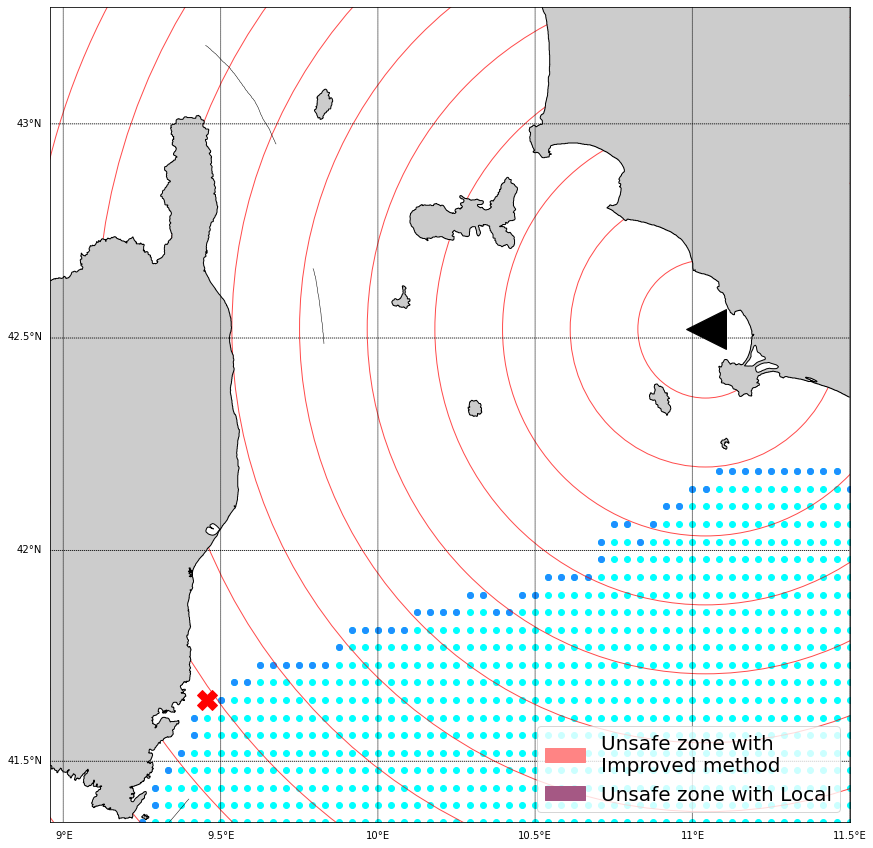

In [124]:
# band_impr_loc3 = np.zeros((47, 62))
# # band_impr_loc3 = band_map[5][7] #+ band_map[5][6] + band_map[5][7]
# band_impr_loc3 += corrected_image2 + band_map[10][10]
# band_impr_loc3 = 100*(np.array(band_impr_loc3)>=1)
r=5
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.plot(sx_init, sy_init, "<k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
# k=9
# mp2.pcolor(x, y, cost[k], cmap=ListedColormap(['white', 'red']))
# plt.scatter(local_x_, local_y_, color="orange")
# plt.scatter(localcont_x_, localcont_y_, color="red")
plt.scatter(intern_x_, intern_y_, color="aqua")  # classic local
plt.scatter(contint_x_, contint_y_, color="dodgerblue")
# plt.plot(x_50_4, y_50_4, "-k", label="Improved method\nRRT*")
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.7, fill = False))

# plt.plot([x for (x, y) in improvedrrt50[r]], [y for (x, y) in improvedrrt50[r]], '-', label="improved")
# plt.plot([x for (x, y) in rrtloc39_geo[r]], [y for (x, y) in rrtloc39_geo[r]], '-', label="rrt")  
# plt.plot([i for i in locpatha39_mp2[r][0]], [i for i in locpatha39_mp2[r][1]], '-', label="a*")
# plt.plot([i[0] for i in locapf39_mp2[r]], [i[1] for i in locapf39_mp2[r]], '-', label="apf")
# plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-')# label="Local RRT*")  
# plt.plot([x for (x, y) in localpath], [y for (x, y) in localpath], '-')#, label="Local RRT*") 
# plt.plot([x for (x, y) in rrt_interp], [y for (x, y) in rrt_interp], '.k',label='Oversampled path points')
# mp2.pcolor(x, y, band_impr_loc3, cmap=ListedColormap(['white', 'red']), alpha=0.8)
# mp2.pcolor(x, y, image, cmap=ListedColormap(['white', 'dodgerblue']), alpha=0.4)

# for i in range(len(rx_rrt_finale)):
#     if i == 0:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20, label='Approximated intersections\npath-temporal bands')
#         plt.text(rx_rrt_finale[i]-10000, ry_rrt_finale[i]+5000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold',
#                             ha='left',va='bottom',color='k')
#     elif i == len(rx_rrt_finale)-1:
#         pass
#     else:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20)
# #     if i == len(rx_rrt_finale)-1:
# #         plt.text(gx_a+15000, gy_a+15000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold', ha='right',va='bottom',color='k')
# #     else:
#         plt.text(rx_rrt_finale[i]-23000, ry_rrt_finale[i]+1000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold',
#                             ha='left',va='bottom',color='k')

        
loc_patch = mpatches.Patch(color='#ff8484', label='Unsafe zone with \nImproved method')
impr1_patch = mpatches.Patch(color='#a55884', label='Unsafe zone with Local')
#a55884
handles, labels = ax.get_legend_handles_labels()
handles.append(loc_patch)
handles.append(impr1_patch)
ax.legend(handles=handles,prop={"size":20}, loc="lower right")
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# plt.savefig("examp2impr.png", dpi=300, bbox_inches='tight')
plt.show()

## Second approach
Build a 4D matrix array considering the contribution of the time window in each temporal band

In [73]:
# 10 are the temporal bands max to reach the two destinations
# 12 are the time-windows max necessary to reach the goal (which means the vehicle takes up to 12 hours)
band_map = [[np.zeros((47, 62)) for i in range(12)] for j in range(10)]

for k in range(len(lats.values)): 
    for j in range(len(lons.values)):
        # compute geodetic distance of each point of the grid from the starting point
        geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(sx,sy))).km
        for q in range(10): # list of bands
            if 18*(q) < geo_dist < 18*(q+1):
                for s in range(12):  # list of temporal bands -> band_map[0] is the band,  band_map[0][0] is the time window 0 in the first band
                    if cost[s][k][j]:
                        band_map[q][s][k][j]=1
                        
## FUNCTION SAMPLING = TO OVERSAMPLING THE PATH AND THE ELLIPSES WITH SPECIFIC FREQUENCY
def sampling(fs, path): ## il path deve essere nel formato di RRT* [[x0,y0], [x1,y1], [x2,y2], ...]
    path_interp = []
    for i in range(len(path)-1): # for all path points
        p1 = path[i]        # point 1
        p2 = path[i+1]      # point 2
        xs = [p1[0],p2[0]]  # = [x1,x2]
        ys = [p1[1],p2[1]]  # = [y1,y2]
        if xs[0] == xs[1]:  # case in which x is the same (vertical movement)
            x_inter = np.array([xs[0] for i in range(fs)]) 
            if ys[0] == ys[1]: # case in which also y is the same
                y_inter = np.array([ys[0] for i in range(fs)])
            elif ys[1] < ys[0]: # case in which y2 < y1   
                y_inter = np.arange(ys[1], ys[0], np.abs((ys[1] - ys[0])) / fs)
            else:
                y_inter = np.arange(ys[0], ys[1], np.abs((ys[1] - ys[0])) / fs)
        elif xs[1] < xs[0]: # case in which x2 < x1  
            x_inter = np.arange(xs[0], xs[1], -np.abs((xs[1]-xs[0]))/fs)
            xs = [p2[0],p1[0]]
            ys = [p2[1],p1[1]]
            y_inter = np.asarray(np.interp(x_inter,xs,ys)) 
        else: # xs[1] > xs[0] normal case
            x_inter = np.arange(xs[0], xs[1], np.abs((xs[1]-xs[0]))/fs)
            y_inter = np.asarray(np.interp(x_inter,xs,ys))
        minn = 0
        if len(y_inter)>len(x_inter): # case in which they do not have the same length
            minn = x_inter
        else:
            minn = y_inter
        for ii in range(len(minn)):
            path_interp.append([x_inter[ii],y_inter[ii]])
    return path_interp

# start by extracting points of the temporal ellipse bands
path = [[] for i in range(le-li)]
ellipseii = [[] for i in range(le-li)]
vertices = [[] for i in range(le-li)]
for i in range(le-li):
    ellipseii[i] = pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1), color='red', alpha=0.7, fill = False)
    ax.add_patch(ellipseii[i])
    path[i] = ellipseii[i].get_path()
    vertices[i] = path[i].vertices.copy()
    vertices[i] = ellipseii[i].get_patch_transform().transform(vertices[i])

xsss = [[] for i in range(le-li)]
ysss = [[] for i in range(le-li)]
for j in range(len(vertices)):
    for i in range(len(vertices[j])):
        xsss[j].append(vertices[j][i][0])
        ysss[j].append(vertices[j][i][1])
        
ellipse_interp = [[] for i in range(le-li)]
iii = 0
for i in range(len(vertices)):
    ellipse_interp[i] = sampling(3*(i+1), vertices[i]) # decide the oversampling factor 2->4->6->8->10

In [2181]:
# when the algorithm must stop?
# The answer is: when safety is assured, which means 
# devo assicure che la path length from start fino ad ogni band border sia inferiore al tempo teorico di mappe sommate
# theoretical_time = [map_diff_corrected[i]+1 for i in range(len(map_diff_corrected))]
# final_condition = [path_until_map[i] > theoretical_time[i] for i in range(len(path_until_map))]
# if (True in final_condition):
#     cond = True
#     print("The map has to be updated")
# else:
#     cond = False
#     print(path_until_map)
#     print(theoretical_time)
#     print("Safety assured, end algorithm")
# theoretical_time = [1+i for i in range(9)]
# theoretical_time 

In [26]:
# a[0:1]
# import matplotlib.patches as mpatches

In [862]:
# band_tot = np.zeros((47, 62))
# for i in range(len(band_map)):
#     band_tot += np.sum(band_map[i][i:i+2],axis=0)
    
# band_tot = 100*(np.array(band_tot)>=1) 

# plt.figure(1, figsize=(15, 10))
# # mp2.pcolor(x, y, band_impr_loc, cmap=ListedColormap(['white', 'red']), alpha=0.6)
# red_patch = mpatches.Patch(color='#ff6666', label='Unsafe region')
# plt.legend(handles=[red_patch],prop={"size":20}, loc="upper right")
# mp2.fillcontinents()
# mp2.drawcoastlines()
# mp2.drawstates()
# mp2.drawcountries()
# mp2.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
# mp2.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes
# # plt.savefig("tryband.png", dpi=300, bbox_inches='tight')
# plt.show()

NameError: name 'band_impr_loc3' is not defined

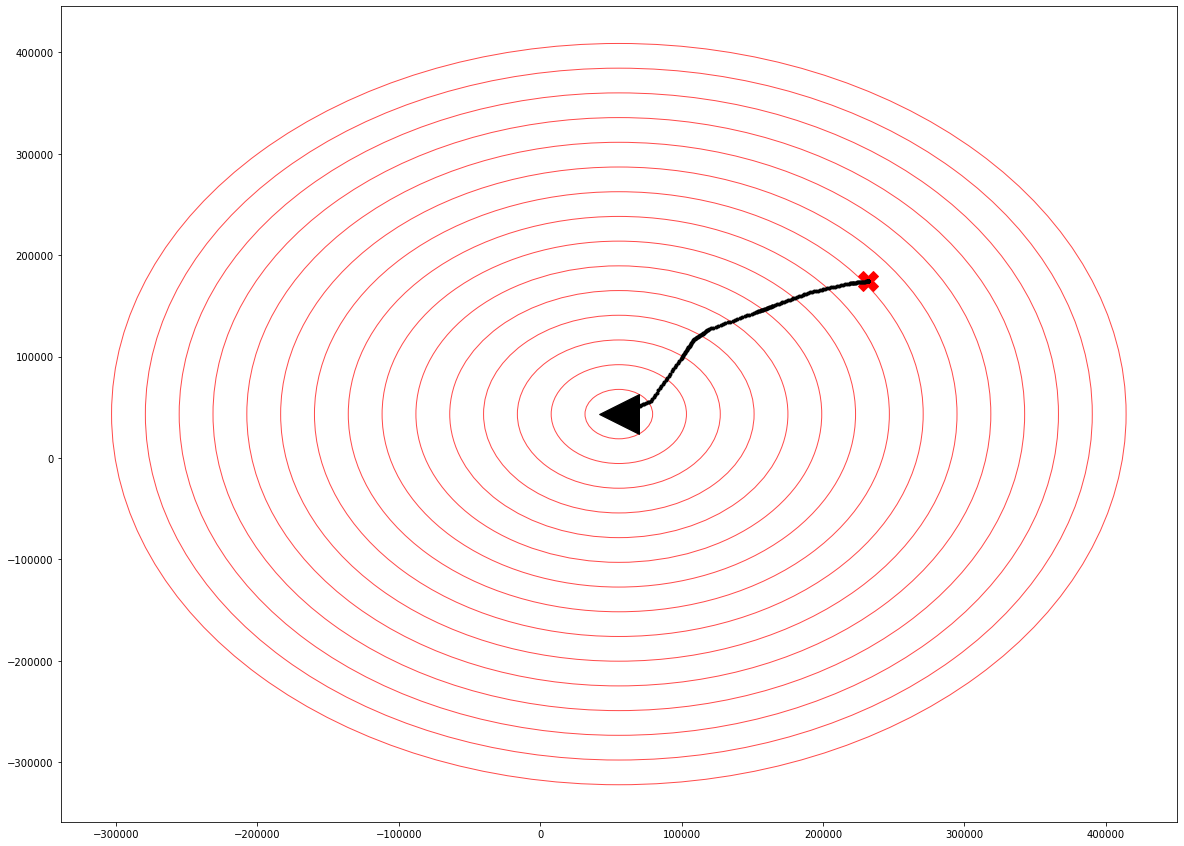

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.plot(sx_init, sy_init, "<k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.7, fill = False))
# plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-')#,label='Improved method RRT*')
plt.plot([x for (x, y) in rrt_interp], [y for (x, y) in rrt_interp], '.k',label='Oversampled path points')
# mp2.pcolor(x, y, band_impr_loc, cmap=ListedColormap(['white', 'red']), alpha=0.8)
# mp2.pcolor(x, y, corrected_image2, cmap=ListedColormap(['white', 'red']), alpha=0.8)
mp2.pcolor(x, y, band_impr_loc3, cmap=ListedColormap(['white', 'red']), alpha=0.8)
mp2.pcolor(x, y, image, cmap=ListedColormap(['white', 'dodgerblue']), alpha=0.4)

for i in range(len(rx_rrt_finale)):
    if i == 0:
        plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20, label='Approximated intersections\npath-temporal bands')
    elif i == len(rx_rrt_finale)-1:
        pass
    else:
        plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20)
    if i == len(rx_rrt_finale)-1:
        plt.text(gx_a+15000, gy_a+5000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold', ha='right',va='bottom',color='k')
    else:
        plt.text(rx_rrt_finale[i]+3000, ry_rrt_finale[i]-10000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold',
                            ha='left',va='bottom',color='k')
loc_patch = mpatches.Patch(color='#ff8484', label='Unsafe zone with \nImproved method iter 2')
impr1_patch = mpatches.Patch(color='#a55884', label='Unsafe zone with \nImproved method iter 1')

#a55884
handles, labels = ax.get_legend_handles_labels()
handles.append(loc_patch)
handles.append(impr1_patch)
ax.legend(handles=handles,prop={"size":20}, loc="lower right")
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# plt.savefig("loc+3impr.png", dpi=300, bbox_inches='tight')
plt.show()

In [2811]:
# corrected_image3 = np.zeros((47, 62))  # initialization image for obstacles
# map_diff = [int(np.ceil(path_until_map[i] - 1*(i+1))) for i in range(len(path_until_map))]  # how many maps need to be added besides the default band's one
# map_diff_corrected = [i + map_diff[i] for i in range(len(map_diff))]                        # at which map to arrive starting from the default band's one
# for i in range(len(map_diff)):
#     if i == 0:                                                                              # at the start, I need to start from the first time window (number 0)
#         corrected_image3 += np.sum(band_map[i][i:map_diff_corrected[i]+1],axis=0)
#     else:                                                                                   # sum time window in each band map_diff_corrected[i-1] which corresponds to the index of the band
#         corrected_image3 += np.sum(band_map[i][map_diff_corrected[i-1]:map_diff_corrected[i]+1],axis=0)
# corrected_image3 = 100*(np.array(corrected_image3)>=1) 

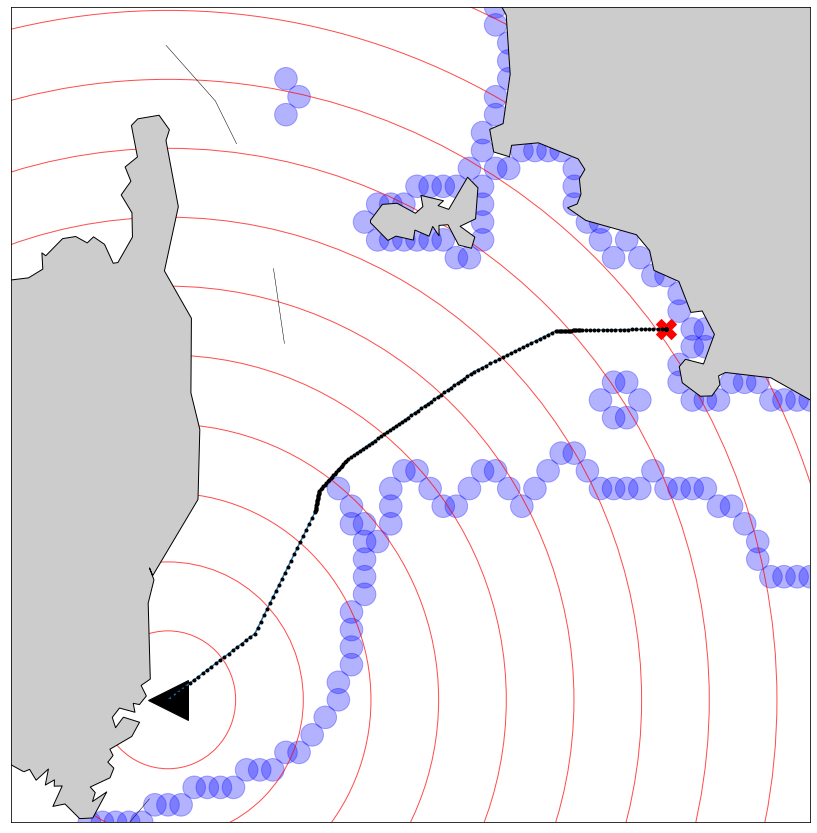

Concluded point-intersection
Concluded point-intersection
Concluded point-intersection
Concluded point-intersection
Concluded point-intersection
Concluded point-intersection
band length i            [1.04, 1.06, 0.99, 1.08, 1.04, 0.96, 1.05, 1.07, 1.39, 0.0] hours
path length until band j [1.04, 2.1, 3.09, 4.17, 5.21, 6.17, 7.22, 8.29, 9.68, 9.68] hours
Min time to do the path 9 h and a little


In [76]:
rrt_interp = sampling(20, path_star)   # interpolated path (first iter is the local path)
rrt_interp.append([gx_a, gy_a])        # append the goal since through sampling it is missed
p_interp = np.zeros_like(rrt_interp)  
for i in range(len(rrt_interp)):       # geo coords of interpolated path
    p_interp[i][0], p_interp[i][1]  = mp2(rrt_interp[i][0], rrt_interp[i][1], inverse=True)  

fig_path_interp()                      # image interpolated path

## find the intersections
rx_rrt = [0 for i in range(len(ellipse_interp))]  # list of intersections
ry_rrt = [0 for i in range(len(ellipse_interp))]
list_of_intersection = [[] for i in range(len(ellipse_interp))]
for i in range(len(ellipse_interp)):              
    for j in range(len(rrt_interp)):
        for k in range(len(ellipse_interp[i])):
            if ellipse_interp[i][k][0] >= sx_init: # condition to take analyze only the points of the positive half <= in case reverse path
                if np.allclose([rrt_interp[j][0],rrt_interp[j][1]], [ellipse_interp[i][k][0], ellipse_interp[i][k][1]], atol=0.0001, rtol=0.020): # tune parameters 0.02058
                    rx_rrt[i] = rrt_interp[j][0]
                    ry_rrt[i] = rrt_interp[j][1]
                    list_of_intersection[i].append([rrt_interp[j][0], rrt_interp[j][1]])  # append to find the best median point
#                     print(i)
#                     print(True)
#     if i < 7:
    if rx_rrt[i] == 0: # if does not find the intersection, break. it means we are over the ending point
        if i < 7: # 7 survey 2, 9 survey 1
            print("Repeat the intersection search")
            print(rx_rrt)
            break
        else:
            print("Concluded point-intersection")


median = []
for i in range(len(list_of_intersection)):
    if len(list_of_intersection[i]) != 0:
        median.append(list_of_intersection[i][int(np.floor(len(list_of_intersection[i])/2))])  # find the best intersection point
    else:
        median.append(0)

rx_rrt_finale = [i[0] for i in median if i != 0] # list of only necessary points
ry_rrt_finale = [i[1] for i in median if i != 0]
rx_rrt_finale.append(gx_a)
ry_rrt_finale.append(gy_a)

path_dist = [0 for i in range(len(rx_rrt_finale))]
for j in range(len(ry_rrt_finale)): # find the distance between each band
    if j == 0: # Start from starting point to the first intersection
        for i in range(rrt_interp.index([rx_rrt_finale[j], ry_rrt_finale[j]])): # starts from 0 to the first 
            path_dist[j] += distance(lonlat(*(p_interp[i][0],p_interp[i][1])), lonlat(*(p_interp[i+1][0],p_interp[i+1][1]))).km
    else: 
        for i in range(rrt_interp.index([rx_rrt_finale[j-1], ry_rrt_finale[j-1]]), rrt_interp.index([rx_rrt_finale[j], ry_rrt_finale[j]])):
            path_dist[j] += distance(lonlat(*(p_interp[i][0],p_interp[i][1])), lonlat(*(p_interp[i+1][0],p_interp[i+1][1]))).km

path_h = [round(path_dist[j]/18,2) for j in range(len(path_dist))]              # list of path length in each band
path_until_map = [round(np.sum(path_h[:j]),2) for j in range(1,len(path_dist)+1)]  # list of path length from start 
time_band_possible = 1*(len(rx_rrt_finale)-1) # -1 because i remove the goal
print(f"band length i            {path_h} hours")
print(f"path length until band j {path_until_map} hours")
print(f"Min time to do the path {time_band_possible} h and a little")

In [75]:
final_condition = [path_until_map[i] > theoretical_time[i] for i in range(len(path_until_map))] # Verify if each path length is smaller than the theoretical time
print(final_condition)

[True, True, True, True, True, True, True, True, True, False]


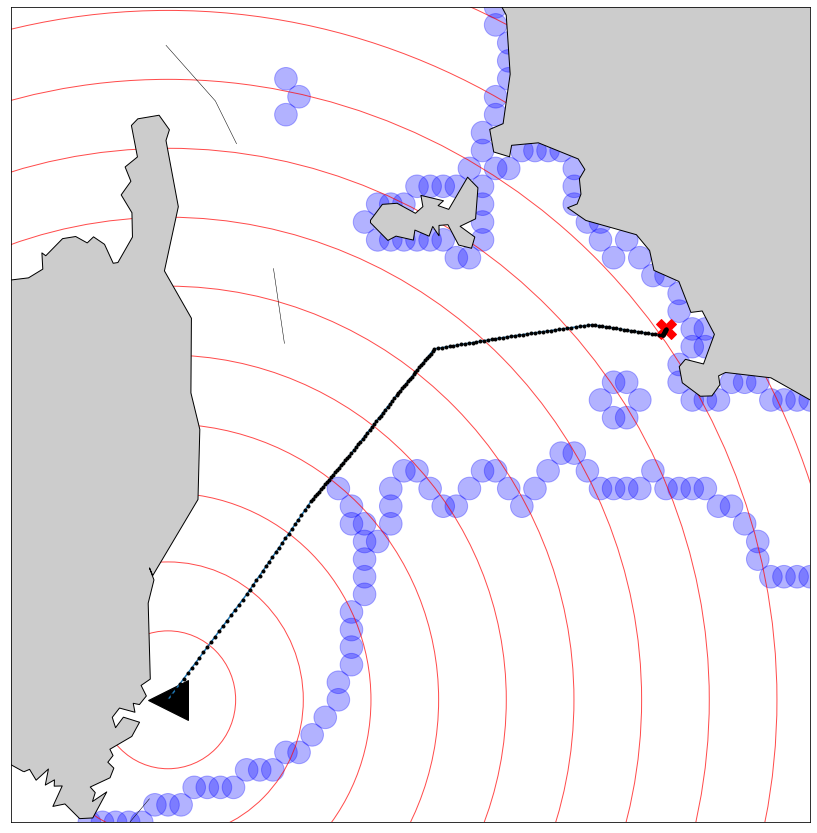

Repeat the intersection search
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
band length i            [9.89] hours
path length until band i [9.89] hours
Min time to do the path 0 h and a little


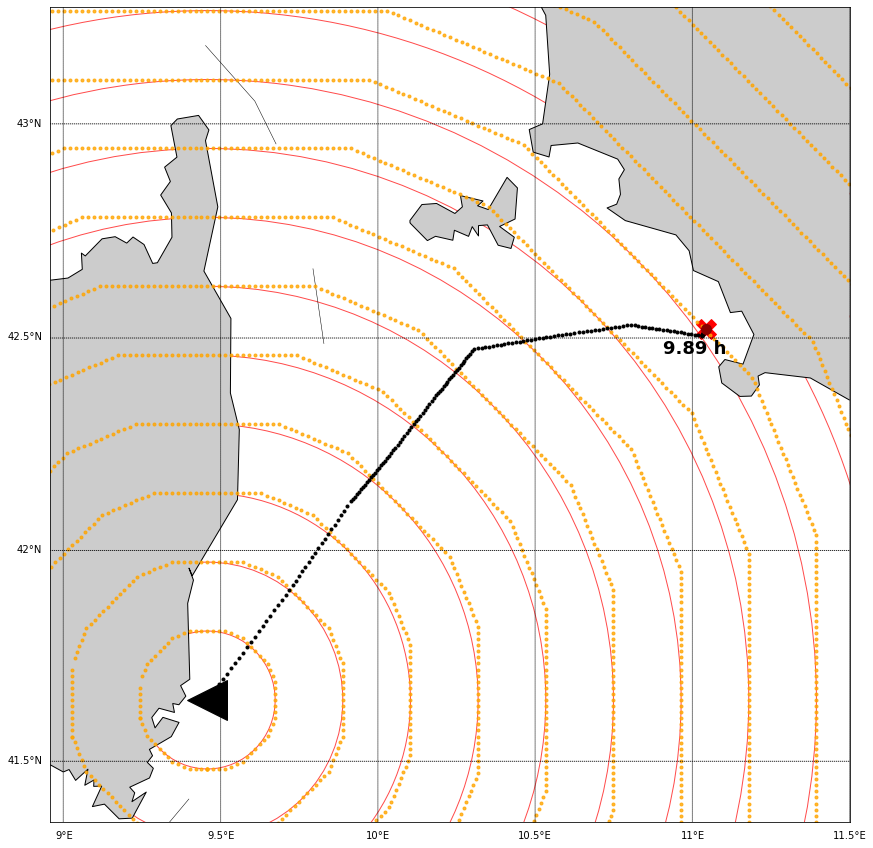

Look at path length from start
Path length until the goal is: 9.89 hours
[True]
The map has to be updated


KeyboardInterrupt: 

In [28]:
## run the path planning algorithm
# sampling the path
cond = True
start_alg_time = time.time()
vak = 0
if sx == xspace[39]:
    theoretical_time = [1+i for i in range(9)]
else:
    theoretical_time = [1+i for i in range(10)]

while cond: # when the algorithm must stop?
    if vak != 0:
        localcont_x = [] # initialization obstacle points
        localcont_y = []
        local_x = []
        local_y = []
        # method 2
        corrected_image2 = np.zeros((47, 62))  # initialization image for obstacles
        map_diff = [int(np.ceil(path_until_map[i] - 1*(i+1))) for i in range(len(path_until_map))]  # how many maps need to be added besides the default band's one
        map_diff_corrected = [i + map_diff[i] for i in range(len(map_diff))]                        # at which map to arrive starting from the default band's one
        for i in range(len(map_diff)):
            if i == 0:                                                                              # at the start, I need to start from the first time window (number 0)
                corrected_image2 += np.sum(band_map[i][i:map_diff_corrected[i]+1],axis=0)
            else:                                                                                   # sum time window in each band map_diff_corrected[i-1] which corresponds to the index of the band
                corrected_image2 += np.sum(band_map[i][map_diff_corrected[i-1]:map_diff_corrected[i]+1],axis=0)
        corrected_image2 = 100*(np.array(corrected_image2)>=1)        

        rrt_contour = np.logical_xor(corrected_image2,binary_erosion(corrected_image2))             # find the contour of the image
        for k in np.arange(0,47,1):
                for j in np.arange(0,62,1):
                    if corrected_image2[k][j]:
                        local_x.append(lons.values[j])
                        local_y.append(lats.values[k])
                    if rrt_contour[k][j]:
                        localcont_x.append(lons.values[j])
                        localcont_y.append(lats.values[k]) 
        localcont_x_, localcont_y_ = mp2(localcont_x, localcont_y)  
        local_x_, local_y_ = mp2(local_x, local_y)  
        
        obstacle_list_ = [[] for i in range(2)]  # define the obstacle list for RRT*
        for i in range(2): # just not to modify the algorithm of RRT*
            for j, _ in enumerate(localcont_x_):
                obstacle_list_[i].append([localcont_x_[j], localcont_y_[j], grid_size])  # new wave obstacles
            for j, _ in enumerate(x_obsl_):
                obstacle_list_[i].append([x_obsl_[j], y_obsl_[j], grid_size])            # land obstacles
        
        rrt_star = RRTStar(
                start=[sx_init, sy_init],
                goal=[gx_a, gy_a],
                rand_area=[x_min, x_max, y_min, y_max],
                obstacle_list=obstacle_list_,
                c_spacex = Cspacex_,
                c_spacey = Cspacey_,
                k = 1,
                speed = 5,
                path_resolution=4500.0,
                connect_circle_dist=300000,
                goal_sample_rate=15,
                expand_dis=4500)

        start_time = time.time()
        path_star, cost_tot, iter_tot = rrt_star.planning(animation=show_animation)
        path_star = list(reversed(path_star))
        end_time = time.time()
        if path_star is None:
            print("Cannot find path")
        else:
            print("Found path!!")
        print("RRT* time: " + str(round(end_time - start_time, 4)) + " seconds")
        p = np.zeros_like(path_star)       # geo coords of RRT* path   
        for i in range(len(path_star)):
            p[i][0], p[i][1]  = mp2(path_star[i][0], path_star[i][1], inverse=True)
        path_dist = 0
        for i in range(len(p)-1):
            path_dist += distance(lonlat(*(p[i][0],p[i][1])), lonlat(*(p[i+1][0],p[i+1][1]))).km
        print("Travel time = ", str(round(path_dist/18,4)), "hours")
    
    rrt_interp = sampling(20, path_star)   # interpolated path (first iter is the local path)
    rrt_interp.append([gx_a, gy_a])        # append the goal since through sampling it is missed
    p_interp = np.zeros_like(rrt_interp)  
    for i in range(len(rrt_interp)):       # geo coords of interpolated path
        p_interp[i][0], p_interp[i][1]  = mp2(rrt_interp[i][0], rrt_interp[i][1], inverse=True)  

    fig_path_interp()                      # image interpolated path

    ## find the intersections
    rx_rrt = [0 for i in range(len(ellipse_interp))]  # list of intersections
    ry_rrt = [0 for i in range(len(ellipse_interp))]
    list_of_intersection = [[] for i in range(len(ellipse_interp))]
    for i in range(len(ellipse_interp)):              
        for j in range(len(rrt_interp)):
            for k in range(len(ellipse_interp[i])):
                if ellipse_interp[i][k][0] >= sx_init: # condition to take analyze only the points of the positive half
                    if np.allclose([rrt_interp[j][0],rrt_interp[j][1]], [ellipse_interp[i][k][0], ellipse_interp[i][k][1]], atol=0.0001, rtol=0.020): # tune parameters 0.02058
                        rx_rrt[i] = rrt_interp[j][0]
                        ry_rrt[i] = rrt_interp[j][1]
                        list_of_intersection[i].append([rrt_interp[j][0], rrt_interp[j][1]])  # append to find the best median point
    #                     print(i)
    #                     print(True)
    #     if i < 7:
        if rx_rrt[i] == 0: # if does not find the intersection, break. it means we are over the ending point
            if i < 7: # 7 survey 2, 9 survey 1
                print("Repeat the intersection search")
                print(rx_rrt)
                break
            else:
                print("Concluded point-intersection")
                

    median = []
    for i in range(len(list_of_intersection)):
        if len(list_of_intersection[i]) != 0:
            median.append(list_of_intersection[i][int(np.floor(len(list_of_intersection[i])/2))])  # find the best intersection point
        else:
            median.append(0)

    rx_rrt_finale = [i[0] for i in median if i != 0] # list of only necessary points
    ry_rrt_finale = [i[1] for i in median if i != 0]
    rx_rrt_finale.append(gx_a)
    ry_rrt_finale.append(gy_a)

    path_dist = [0 for i in range(len(rx_rrt_finale))]
    for j in range(len(ry_rrt_finale)): # find the distance between each band
        if j == 0: # Start from starting point to the first intersection
            for i in range(rrt_interp.index([rx_rrt_finale[j], ry_rrt_finale[j]])): # starts from 0 to the first 
                path_dist[j] += distance(lonlat(*(p_interp[i][0],p_interp[i][1])), lonlat(*(p_interp[i+1][0],p_interp[i+1][1]))).km
        else: 
            for i in range(rrt_interp.index([rx_rrt_finale[j-1], ry_rrt_finale[j-1]]), rrt_interp.index([rx_rrt_finale[j], ry_rrt_finale[j]])):
                path_dist[j] += distance(lonlat(*(p_interp[i][0],p_interp[i][1])), lonlat(*(p_interp[i+1][0],p_interp[i+1][1]))).km

    path_h = [round(path_dist[j]/18,2) for j in range(len(path_dist))]              # list of path length in each band
    path_until_map = [round(np.sum(path_h[:j]),2) for j in range(1,len(path_dist)+1)]  # list of path length from start 
    time_band_possible = 1*(len(rx_rrt_finale)-1) # -1 because i remove the goal
    print(f"band length i            {path_h} hours")
    print(f"path length until band i {path_until_map} hours")
    print(f"Min time to do the path {time_band_possible} h and a little")

    fig_with_intersection()  # image with intersection and lengths

    print(f"Look at path length from start")
    for i in range(len(path_until_map)):
        if i == len(path_until_map)-1:
            print(f"Path length until the goal is: {path_until_map[i]} hours")
        else:
            print(f"Path length until the end of band {i} is: {path_until_map[i]} hours")
    
    if vak != 0:
        theoretical_time = [map_diff_corrected[i]+1 for i in range(len(map_diff_corrected))]            # Time to pass each band based of maps considered
    
    final_condition = [path_until_map[i] > theoretical_time[i] for i in range(len(path_until_map))] # Verify if each path length is smaller than the theoretical time
    print(final_condition)
    if (True in final_condition):
        cond = True
        print("The map has to be updated")
    else:
        cond = False
        print(path_until_map)
        print(theoretical_time)
        print("Safety assured, end algorithm")
    vak = 1
        
end_alg_time = time.time()
print("The computing time of the algorithm is " + str(round(end_alg_time - start_alg_time, 4)) + " seconds")

<ipython-input-928-2691e18a4fa7>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp2.pcolor(x, y, corrected_image2, cmap=ListedColormap(['white', 'red']), alpha=0.6)


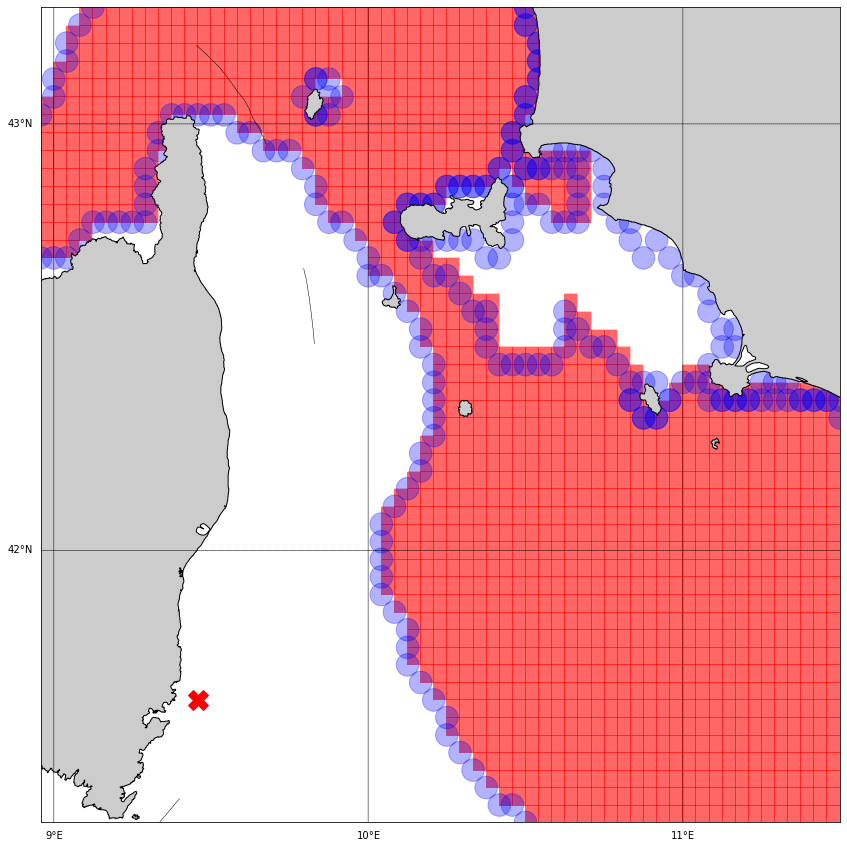

In [928]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp2.pcolor(x, y, corrected_image2, cmap=ListedColormap(['white', 'red']), alpha=0.6)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
for i in range(len(obstacle_list_[0])):
    ax.add_patch(plt.Circle(xy=(obstacle_list_[0][i][0], obstacle_list_[0][i][1]), radius=4000,
                            color='b', alpha=0.3))
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
mp2.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes
# plt.savefig("tryband.png", dpi=300, bbox_inches='tight')
plt.show()

In [140]:
# if vak != 0:
#     theoretical_time = [map_diff_corrected[i]+1 for i in range(len(map_diff_corrected))]            # Time to pass each band based of maps considered
    
# final_condition = [path_until_map[i] > theoretical_time[i] for i in range(len(path_until_map))] # Verify if each path length is smaller than the theoretical time
# print(final_condition)
# if (True in final_condition):
#     cond = True
#     print("The map has to be updated")
# else:
#     cond = False
#     print(path_until_map)
#     print(theoretical_time)
#     print("Safety assured, end algorithm")

In [1702]:
# print(path_until_map)
# print(map_diff_corrected)

In [141]:
improvedrrt50 = [[] for i in range(12)]
improvedrrt39 = [[] for i in range(12)]

In [486]:
improvedrrt50[11] = path_star # None

In [494]:
improvedrrt39[11] = path_star

In [33]:
import pickle
# file_name = "improvedrrt39.pkl"
# open_file = open(file_name, "wb")
# pickle.dump(improvedrrt39, open_file)
# open_file.close()
file_name = "improvedrrt50.pkl" 
open_file = open(file_name, "rb")
improvedrrt50 = pickle.load(open_file)
open_file.close()

In [1543]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 15))
# plt.plot(sx_init, sy_init, ">k", markersize=40)
# plt.plot(gx_a, gy_a, "Xr", markersize=20)
# for j in range(len(ellipse_interp)):
#     plt.plot([x for (x, y) in ellipse_interp[j]], [y for (x, y) in ellipse_interp[j]], '.', color="orange", alpha=0.8)
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
#                                 color='red', alpha=0.7, fill = False))
# plt.plot([x for (x, y) in rrt_interp], [y for (x, y) in rrt_interp], '.k',label='interpolated points')
# for i in range(len(rx_rrt_finale)):
#     if i == 0:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20, label='approximated intersections path-temporal bands')
#     else:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20)
#     if i == len(rx_rrt_finale)-1:
#         plt.text(gx_a+15000, gy_a+5000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold', ha='right',va='bottom',color='k')
#         plt.text(gx_a+15000, gy_a-5000, "+" + str(map_diff[i]), fontsize=18,fontweight='bold', ha='right',va='bottom',color='blue')
#     else:
#         plt.text(rx_rrt_finale[i]-3000, ry_rrt_finale[i]+2000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold',
#                             ha='right',va='bottom',color='k')
#         plt.text(rx_rrt_finale[i]+3000, ry_rrt_finale[i]-15000, "+" + str(map_diff[i]), fontsize=18,fontweight='bold',
#                     ha='right',va='bottom',color='blue')
        
    
# mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
# mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
# mp2.fillcontinents()
# mp2.drawcoastlines()
# mp2.drawstates()
# mp2.drawcountries()
# plt.show()

In [1401]:
# method 1
# corrected_image = np.zeros((47, 62))
# map_diff = [int(np.ceil(path_until_map[i] - 1*(i+1))) for i in range(len(path_until_map))]

# for i in range(len(map_diff)):
#     corrected_image += np.sum(band_map[i][i:i+map_diff[i]+1],axis=0)
# corrected_image = 100*(np.array(corrected_image)>=1)

In [34]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 15))
# plt.plot(sx_init, sy_init, ">k", markersize=40)
# i= 0

# # mp2.pcolor(x, y, corrected_image, cmap=ListedColormap(['white', 'blue']), alpha=0.5)
# # mp2.pcolor(x, y, corrected_image2, cmap=ListedColormap(['white', 'green']), alpha=0.5)
# # mp2.pcolor(x, y, image, cmap=ListedColormap(['white', 'red']), alpha=0.5)
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
#                             color='red', alpha=0.7, fill = False))
# plt.plot([x for (x, y) in rrt_interp], [y for (x, y) in rrt_interp], '.k',label='interpolated points')
# for i in range(len(rx_rrt_finale)):
#     if i == 0:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20, label='approximated intersections path-temporal bands')
#     else:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20)
#     if i == len(rx_rrt_finale)-1:
#         plt.text(gx_a+15000, gy_a+5000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold', ha='right',va='bottom',color='k')
#         plt.text(gx_a+15000, gy_a-5000, "$b_" +str(i)+"$ +" + str(map_diff[i]), fontsize=18,fontweight='bold', ha='right',va='bottom',color='blue')
#     else:
#         plt.text(rx_rrt_finale[i]-3000, ry_rrt_finale[i]+2000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold',
#                             ha='right',va='bottom',color='k')
#         plt.text(rx_rrt_finale[i]+3000, ry_rrt_finale[i]-15000, "$b_" +str(i)+"$ +" + str(map_diff[i]), fontsize=18,fontweight='bold',
#                     ha='right',va='bottom',color='blue')
# plt.scatter(local_x_, local_y_, color="orange") 
# plt.scatter(localcont_x_, localcont_y_, color="red", label='New map cont')   
  
# mp2.fillcontinents()
# mp2.drawcoastlines()
# mp2.drawstates()
# mp2.drawcountries()
# mp2.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
# mp2.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes

# plt.show()

## Plotting days

### Survey 1

In [256]:

x_50 = []
y_50 = []
k = 5

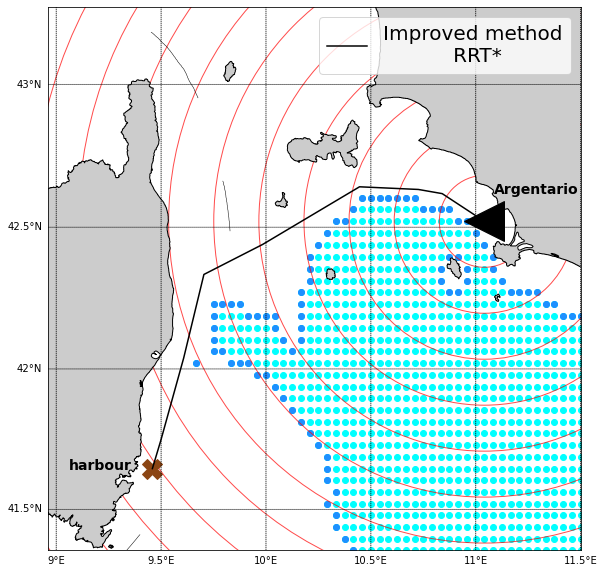

In [257]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(sx_init, sy_init, "<k", markersize=40)
plt.plot(gx_a, gy_a, "X", color='saddlebrown', markersize=20)
plt.text(sx_init+5000, sy_init+13000, 'Argentario',fontsize=14,fontweight='bold',
                    ha='left',va='bottom',color='k')
plt.text(gx_a-11000, gy_a-2000, 'harbour',fontsize=14, fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.scatter(local_x_, local_y_, color="aqua")
plt.scatter(localcont_x_, localcont_y_, color="dodgerblue")
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.7, fill = False))
# plt.plot(x_50, y_50, '-k', label="Improved method\n           RRT*")    
plt.plot([x for (x, y) in improvedrrt50[k]], [y for (x, y) in improvedrrt50[k]], '-k', label="Improved method\n           RRT*")
# for i in range(len(rx_rrt_finale)):
#     if i == 0:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20, label='Intersections path-temporal bands')
#     else:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20)
#     if i == len(rx_rrt_finale)-1:
#         plt.text(gx_a+4000, gy_a-15000, str(round(path_dist[i]/18,2)) + " h",fontsize=12,fontweight='bold', ha='right',va='bottom',color='k')
#     else:
#         plt.text(rx_rrt_finale[i]-1000, ry_rrt_finale[i]+5000, str(round(path_dist[i]/18,2)) + " h",fontsize=12,fontweight='bold',
#                             ha='right',va='bottom',color='k')
# plt.scatter(local_x_, local_y_, color="aqua")
# plt.scatter(localcont_x_, localcont_y_, color="dodgerblue")
# for i in index:
#     plt.plot(rrt_interp[i][0],rrt_interp[i][1], '.', color="blue", markersize=20)
ax.legend(prop={"size":20}, loc="upper right")
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# plt.savefig("day2impr50.png", dpi=300, bbox_inches='tight')
plt.show()


In [2615]:
band_impr_loc3 = np.zeros((47, 62))
band_impr_loc3 = band_map[5][7] #+ band_map[5][6] + band_map[5][7]
# band_impr_loc += corrected_image2 + band_map[9][9] + band_map[10][10]
band_impr_loc3 = 100*(np.array(band_impr_loc3)>=1)

<ipython-input-2621-1947c23fab40>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp2.pcolor(x, y, band_impr_loc3, cmap=ListedColormap(['white', 'dodgerblue']), alpha=0.7, label='Improved method')


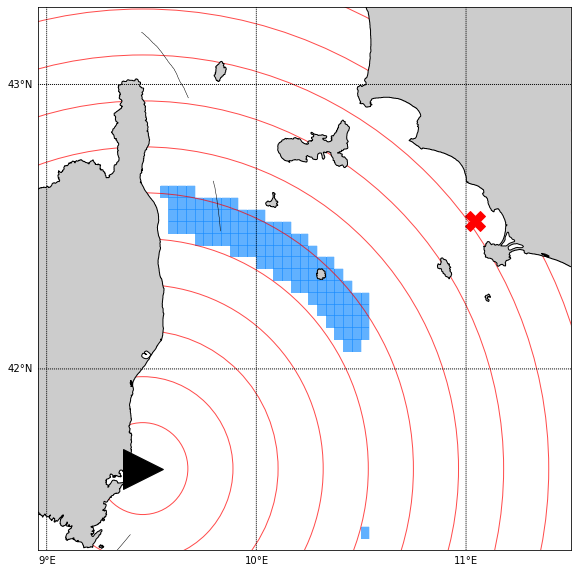

In [2621]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(sx_init, sy_init, ">k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
# mp2.pcolor(x, y, cost15, cmap=ListedColormap(['white', 'red']), alpha=0.6, label='Sum')
# mp2.pcolor(x, y, corrected_image2, cmap=ListedColormap(['white', 'dodgerblue']), alpha=0.6, label='Improved')
# mp2.pcolor(x, y, band_map[9][9], cmap=ListedColormap(['white', 'red']), alpha=0.5, label='Sum')
mp2.pcolor(x, y, band_impr_loc3, cmap=ListedColormap(['white', 'dodgerblue']), alpha=0.7, label='Improved method')
# mp2.pcolor(x, y, band_impr_loc2, cmap=ListedColormap(['white', 'red']), alpha=0.5, label='Improved method')
# mp2.pcolor(x, y, band_impr_loc3, cmap=ListedColormap(['white', 'red']), alpha=0.3, label='Improved method')
# mp2.pcolor(x, y, image, cmap=ListedColormap(['white', 'red']), alpha=0.6, label='Local')
# red_patch = mpatches.Patch(color='#ff6666', label='band_map[5][5]')
# ax.legend(handles=[red_patch],prop={"size":20}, loc="upper right")
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.7, fill = False))
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
mp2.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes
plt.savefig("bandmap57.png", dpi=300, bbox_inches='tight')
plt.show()

### Survey 2

In [164]:
x_50 = []
y_50 = []
k = 9

In [165]:
len(improvedrrt39)

12

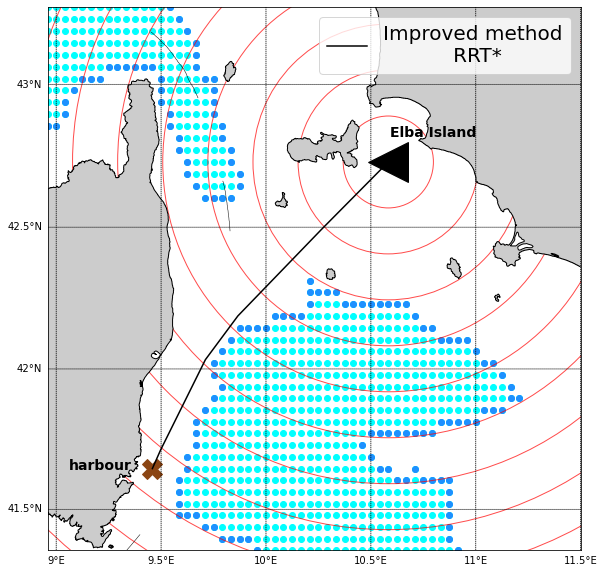

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(sx_init, sy_init, "<k", markersize=40)
plt.plot(gx_a, gy_a, "X", color='saddlebrown', markersize=20)
plt.text(sx_init+1000, sy_init+12000, 'Elba Island',fontsize=14,fontweight='bold',
                    ha='left',va='bottom',color='k')
plt.text(gx_a-11000, gy_a-2000, 'harbour',fontsize=14, fontweight='bold',
                    ha='right',va='bottom',color='k')
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.7, fill = False))
# plt.plot(x_50, y_50, '-k', label="Improved method\n           RRT*")        
plt.plot([x for (x, y) in improvedrrt39[k]], [y for (x, y) in improvedrrt39[k]], '-k', label="Improved method\n           RRT*")
# for i in range(len(rx_rrt_finale)):
#     if i == 0:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20, label='Intersections path-temporal bands')
#     else:
#         plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20)
#     if i == len(rx_rrt_finale)-1:
#         plt.text(gx_a+4000, gy_a-15000, str(round(path_dist[i]/18,2)) + " h",fontsize=12,fontweight='bold', ha='right',va='bottom',color='k')
#     else:
#         plt.text(rx_rrt_finale[i]-1000, ry_rrt_finale[i]+5000, str(round(path_dist[i]/18,2)) + " h",fontsize=12,fontweight='bold',
#                             ha='right',va='bottom',color='k')
plt.scatter(local_x_, local_y_, color="aqua")
plt.scatter(localcont_x_, localcont_y_, color="dodgerblue")
ax.legend(prop={"size":20}, loc="upper right")
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig("day4impr39.png", dpi=300, bbox_inches='tight')
plt.show()


## Start by implementing IMPROVED SUM 1

In [2530]:
cost15 = 0
for i in range(len(cost)):
    cost15 += cost[i]
cost15 = 100*(np.array(cost15)>=100)

contour15 = np.logical_xor(cost15,binary_erosion(cost15))

In [582]:
xspace = lons.values
yspace = lats.values

sx = xspace[12]  
sy = yspace[7] 
gx = xspace[50]   # 39
gy = yspace[28]   # 33
sx_init, sy_init = mp2(sx, sy)
gx_a, gy_a = mp2(gx, gy)



In [331]:
oxmeteo, oymeteo = [[] for i in range(le-li)], [[] for i in range(le-li)]     # all meteo points
oxmeteo_, oymeteo_ = [[] for i in range(le-li)], [[] for i in range(le-li)]   # all meteo points
x_obsm, y_obsm = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
x_obsm_, y_obsm_ = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
x_obsl, y_obsl = [], []
Cspacex, Cspacey = [], []
map_x, map_y = [], []  # point coordinates of the image
map_x_, map_y_ = [], [] 
map_x2, map_y2 = [], []  
map_x_2, map_y_2 = [], [] 
image = np.zeros((47, 62))

for i in range(le-li):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(xspace[12],yspace[7]))).km
            if 18*(i) < geo_dist < 18*(i+1):
                costsum = 0
                # sum all the maps starting from the map i, which means in the second band I exclude the first map
                for r in range(i,len(cost)): 
                    costsum += cost[r]
                costsum = 100*(np.array(costsum)>=100)
                if costsum[k][j]:
                    image[k][j]=1
                    map_x.append(lons.values[j])
                    map_y.append(lats.values[k]) 
    oxmeteo_[i], oymeteo_[i] = mp2(oxmeteo[i], oymeteo[i]) 

astar_contour = np.logical_xor(image,binary_erosion(image)) 
for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if astar_contour[k][j]:
                map_x2.append(lons.values[j])
                map_y2.append(lats.values[k]) 
                
map_x_, map_y_ = mp2(map_x, map_y)              
map_x_2, map_y_2 = mp2(map_x2, map_y2)       # map contour points     

for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]: 
                    if lons_mask.values[j] > 9.8:
                        x_obsl.append(lons_mask.values[j])
                        y_obsl.append(lats_mask.values[k])
                if mask.values[k][j] == 1:
                    Cspacex.append(lons_mask.values[j])
                    Cspacey.append(lats_mask.values[k])
                    
Cspacex_, Cspacey_ = mp2(Cspacex, Cspacey)                   
x_obsl_, y_obsl_ = mp2(x_obsl, y_obsl)       # coastline points

### if we want to compare it with the classic SUM method

In [327]:
# sum classico
cost15 = 0
for i in range(len(cost)):
    cost15 += cost[i]
cost15 = 100*(np.array(cost15)>=100)

contour15 = np.logical_xor(cost15,binary_erosion(cost15))

oxmeteo, oymeteo = [], []     # all meteo points
x_obsm, y_obsm = [], []       # contour meteo points
oxmeteo_, oymeteo_ = [], []   # all meteo points
x_obsm_, y_obsm_ = [], []     # contour meteo points


for k in np.arange(0,47,1):
    for j in np.arange(0,62,1):
        if cost15[k][j]:
            oxmeteo.append(lons.values[j])
            oymeteo.append(lats.values[k])
        if contour15[k][j]:
            x_obsm.append(lons.values[j])
            y_obsm.append(lats.values[k])
x_obsm_, y_obsm_ = mp2(x_obsm, y_obsm)       # meteo contour points
oxmeteo_, oymeteo_ = mp2(oxmeteo, oymeteo)

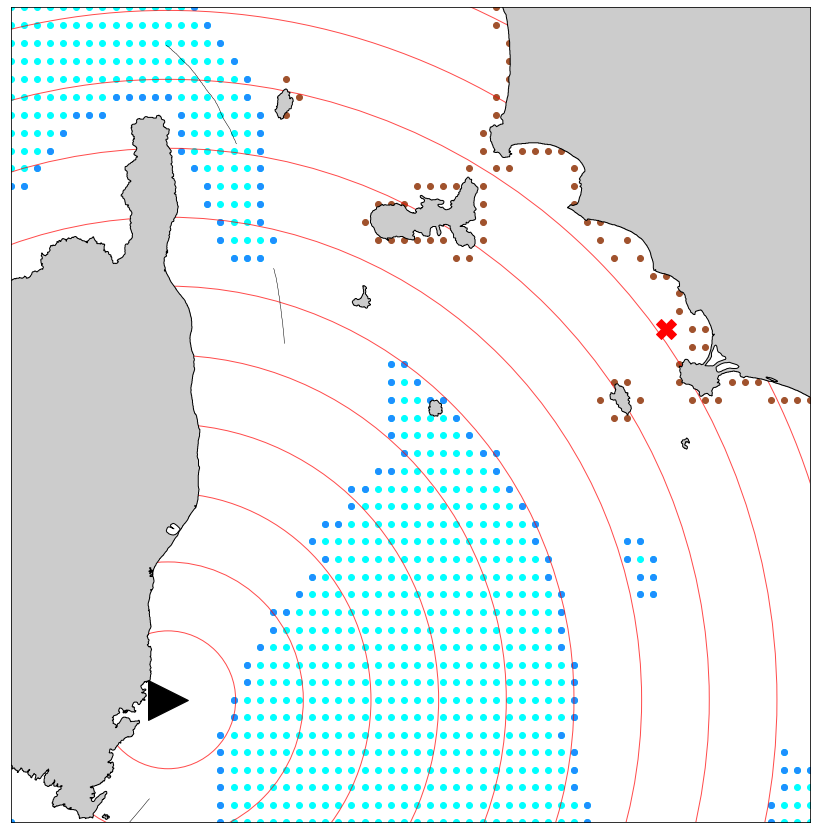

In [584]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.plot(sx_init, sy_init, ">k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)


# plt.plot(oxmeteo_, oymeteo_, '.', color="orange") # classic sum
# plt.plot(x_obsm_, y_obsm_, '.', color="red")

# plt.scatter(map_x_, map_y_,  color="aqua")  # improved sum
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")


plt.scatter(intern_x_, intern_y_, color="aqua")  # classic local
plt.scatter(contint_x_, contint_y_, color="dodgerblue")
# mp.pcolor(x, y, cost[14], cmap=ListedColormap(['white', 'red']))
plt.scatter(x_obsl_, y_obsl_, color="sienna")
# plt.plot(map_x_2, map_y_2, '.', color="sienna")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(sx_init, sy_init), radius=18000*(i+1),
#                                 color='red', alpha=0.5, fill = False))
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.7, fill = False))
# plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.show()

#### IMPROVED SUM v1 tends to be equal to SUM near the starting point. More we move away from it, less temporal maps will be considered and better performances are achieved

## FOCUS TO IMPROVED SUM V2

I want to compute the path length in each temporal band. So I need a oversampled path

In [47]:
def sampling(fs, path): ## il path deve essere nel formato di RRT*
    path_interp = []
    for i in range(len(path))[:-1]:
        p1 = path[i]
        p2 = path[i+1]
        xs = [p1[0],p2[0]]
        ys = [p1[1],p2[1]]
#         print(xs, ys)
        if xs[0] == xs[1]:
            x_inter = np.array([xs[0] for i in range(fs)])
            if ys[0] == ys[1]:
                y_inter = np.array([ys[0] for i in range(fs)])
            else:    
                if ys[1] < ys[0]:
                    y_inter = np.arange(ys[1], ys[0], np.abs((ys[1] - ys[0])) / fs)
                else:
                    y_inter = np.arange(ys[0], ys[1], np.abs((ys[1] - ys[0])) / fs)
        else:
            if xs[1] < xs[0]:
                x_inter = np.arange(xs[1], xs[0], np.abs((xs[1]-xs[0]))/fs)
                xs = [p2[0],p1[0]]
                ys = [p2[1],p1[1]]
                y_inter = np.asarray(np.interp(x_inter,xs,ys)) 
            else: # xs[1] > xs[0] normal case
                x_inter = np.arange(xs[0], xs[1], np.abs((xs[1]-xs[0]))/fs)
                y_inter = np.asarray(np.interp(x_inter,xs,ys)) 
#         print(y_inter)
        for ii in range(len(y_inter)):
            path_interp.append([x_inter[ii],y_inter[ii]])
    path_interp.append(astar[-1])
    return path_interp


In [25]:
### A*
grid_size = 0.04166
robot_radius = grid_size
start_time = time.time()
a_star = AStarPlanner(map_x2, map_y2, grid_size, robot_radius, xspace[0], yspace[0], xspace[-1], yspace[-1])
rx, ry = a_star.planning(sx, sy, gx, gy)
print("Computational time is {} seconds".format(round(time.time() - start_time,3)))
rx = list(reversed(rx))
ry = list(reversed(ry))
astar = []
for i in range(len(rx)):
    astar.append([rx[i], ry[i]])
    
len(astar)

min_x: 8.958333969116211°
min_y: 41.35416793823242°
max_x: 11.500000953674316°
max_y: 43.27083206176758°
x_width: 62
y_width: 47
Find goal
Computational time is 3.031 seconds


40

In [691]:
astar_interp = sampling(3, astar)
astar_interp__ = []
for i in range(len(astar_interp)):
    temp1, temp2 = mp(astar_interp[i][0], astar_interp[i][1])
    astar_interp__.append([temp1, temp2])

Travel time =  10.1034 hours


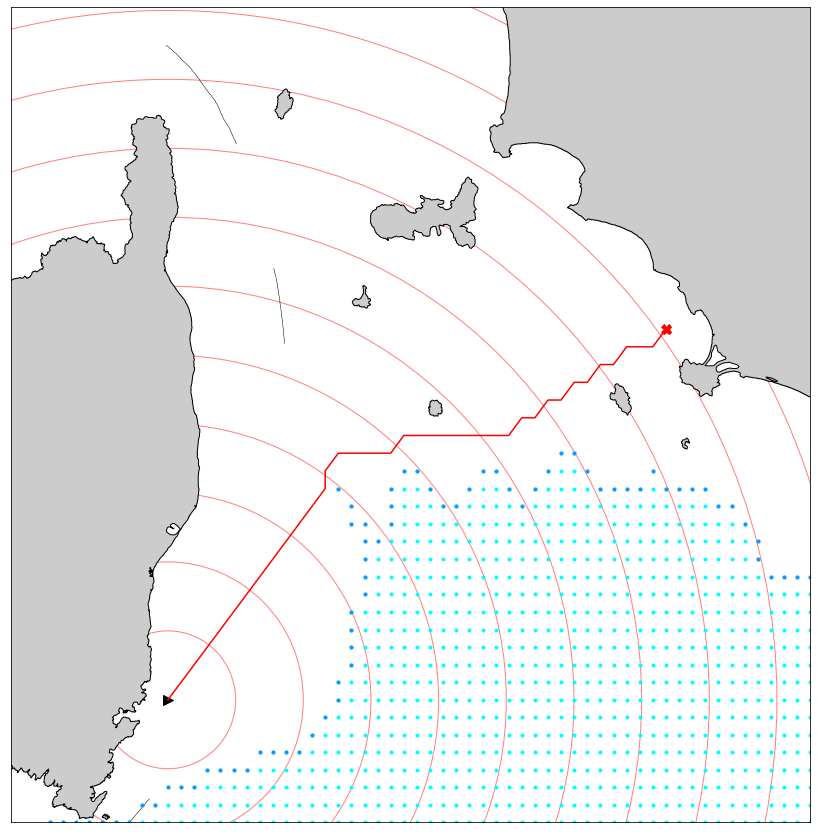

In [28]:
path_dist = 0
for i in range(len(rx)-1):
    path_dist += distance(lonlat(*(rx[i],ry[i])), lonlat(*(rx[i+1],ry[i+1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

rx_, ry_ = mp2(rx, ry)
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp2.plot(sx_init, sy_init, ">k", markersize=10)
mp2.plot(gx_a, gy_a, "Xr", markersize=10)

# mp2.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp2.plot(rx_, ry_, '-r')
# mp.plot(rx_, ry_, '.k')
plt.plot(map_x_, map_y_, '.', color="aqua")  # improved sum
plt.plot(map_x_2, map_y_2, '.', color="dodgerblue")
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.5, fill = False))
# plt.plot([x for (x, y) in astar_interp__], [y for (x, y) in astar_interp__], '.b',label='interp')
# plt.plot([x for (x, y) in astar_interp__], [y for (x, y) in astar_interp__], '.b',label='interp')
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# plt.savefig("prova233.png", dpi=300)
plt.show()

# Iterative algorithm ``Improved Local``

In [595]:
## function sampling, to sampling the path and the ellipses with higher frequency
def sampling(fs, path): ## il path deve essere nel formato di RRT*
    path_interp = []
    for i in range(len(path)-1):
        p1 = path[i]
        p2 = path[i+1]
        xs = [p1[0],p2[0]]
        ys = [p1[1],p2[1]]
        if xs[0] == xs[1]:
            x_inter = np.array([xs[0] for i in range(fs)])
            if ys[0] == ys[1]:
                y_inter = np.array([ys[0] for i in range(fs)])
            else:    
                if ys[1] < ys[0]:
                    y_inter = np.arange(ys[1], ys[0], np.abs((ys[1] - ys[0])) / fs)
                else:
                    y_inter = np.arange(ys[0], ys[1], np.abs((ys[1] - ys[0])) / fs)
        else:
            if xs[1] < xs[0]:
                x_inter = np.arange(xs[1], xs[0], np.abs((xs[1]-xs[0]))/fs)
                xs = [p2[0],p1[0]]
                ys = [p2[1],p1[1]]
                y_inter = np.asarray(np.interp(x_inter,xs,ys)) 
            else: # xs[1] > xs[0] normal case
                x_inter = np.arange(xs[0], xs[1], np.abs((xs[1]-xs[0]))/fs)
                y_inter = np.asarray(np.interp(x_inter,xs,ys))
        minn = 0
        if len(y_inter)>len(x_inter):
            minn = x_inter
        else:
            minn = y_inter
        for ii in range(len(minn)):
            path_interp.append([x_inter[ii],y_inter[ii]])
#     path_interp.append(astar[-1])
    return path_interp

In [611]:
# start by defining the ellipses or temporal bands
path = [[] for i in range(le-li)]
ellipseii = [[] for i in range(le-li)]
vertices = [[] for i in range(le-li)]
for i in range(le-li):
    ellipseii[i] = pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1), color='red', alpha=0.7, fill = False)
    ax.add_patch(ellipseii[i])
    path[i] = ellipseii[i].get_path()
    vertices[i] = path[i].vertices.copy()
    vertices[i] = ellipseii[i].get_patch_transform().transform(vertices[i])

xsss = [[] for i in range(le-li)]
ysss = [[] for i in range(le-li)]
for j in range(len(vertices)):
    for i in range(len(vertices[j])):
        xsss[j].append(vertices[j][i][0])
        ysss[j].append(vertices[j][i][1])

ellipse_interp = [[] for i in range(le-li)]
iii = 0
for i in range(len(vertices)):
    ellipse_interp[i] = sampling(2*(i+1), vertices[i])
    
    
## run the path planning algorithm

# sampling the path
rrt_interp = sampling(12, path_star)   # interpolated path
p_interp = np.zeros_like(rrt_interp)  
for i in range(len(rrt_interp)):
    p_interp[i][0], p_interp[i][1]  = mp2(rrt_interp[i][0], rrt_interp[i][1], inverse=True)  ## geo coords of interpolated path
    
# find the intersection
rx_rrt = [0 for i in range(len(ellipse_interp))]  # list of intersections
ry_rrt = [0 for i in range(len(ellipse_interp))]
list_of_intersection = [[] for i in range(len(ellipse_interp))]
start_time = time.time()
for i in range(len(ellipse_interp)):
    for j in range(len(rrt_interp)):
        for k in range(len(ellipse_interp[i])):
            if ellipse_interp[i][k][0] >= sx_init:
                if np.allclose([rrt_interp[j][0],rrt_interp[j][1]], 
                               [ellipse_interp[i][k][0], ellipse_interp[i][k][1]], atol=0.0001, rtol=0.027): # tune parameters 0.02058
                    rx_rrt[i] = rrt_interp[j][0]
                    ry_rrt[i] = rrt_interp[j][1]
                    list_of_intersection[i].append([rrt_interp[j][0], rrt_interp[j][1]])
                
#                     print(i)
#                     print(True)
    if rx_rrt[i] == 0:
        break
print("The computational time is " + str(round(time.time() - start_time, 4)) + " seconds")                                        

median = []
for i in range(len(list_of_intersection)):
    if len(list_of_intersection[i]) != 0:
        median.append(list_of_intersection[i][int(np.floor(len(list_of_intersection[i])/2))])
    else:
        median.append(0)
    
rx_rrt_finale = [i[0] for i in median if i != 0]
ry_rrt_finale = [i[1] for i in median if i != 0]

path_dist = [0 for i in range(len(ellipse_interp))]
for j in range(len(ry_rrt_finale)+1):
    if j == 0: # Start from starting point to the first intersection
        for i in range(rrt_interp.index([median[j][0], median[j][1]])):
            path_dist[j] += distance(lonlat(*(p_interp[i][0],p_interp[i][1])), 
                                     lonlat(*(p_interp[i+1][0],p_interp[i+1][1]))).km
    else: 
        if j == len(rx_rrt_finale): # I go from the last intersection to the goal
            for i in range(rrt_interp.index([rx_rrt_finale[j-1], ry_rrt_finale[j-1]]), len(rrt_interp)-1):  
                path_dist[j] += distance(lonlat(*(p_interp[i][0],p_interp[i][1])),
                                         lonlat(*(p_interp[i+1][0],p_interp[i+1][1]))).km
        else:
            for i in range(rrt_interp.index([median[j-1][0], median[j-1][1]]), 
                           rrt_interp.index([median[j][0], median[j][1]])):
                path_dist[j] += distance(lonlat(*(p_interp[i][0],p_interp[i][1])),
                                         lonlat(*(p_interp[i+1][0],p_interp[i+1][1]))).km
            
    
    print(f"band {j}")
    print("Travel time = ", str(round(path_dist[j]/18,2)), "hours")

# I have found the intersections and the path lengths
# now I have to modify the temporal bands

The computational time is 9.7599 seconds
band 0
Travel time =  0.93 hours
band 1
Travel time =  1.12 hours
band 2
Travel time =  1.02 hours
band 3
Travel time =  1.09 hours
band 4
Travel time =  0.96 hours
band 5
Travel time =  1.11 hours
band 6
Travel time =  1.36 hours
band 7
Travel time =  1.47 hours
band 8
Travel time =  1.11 hours
band 9
Travel time =  0.0 hours


In [705]:
path_h = [round(path_dist[j]/18,2) for j in range(len(path_dist))]
path_until_map = [round(np.sum(path_h[:j]),2) for j in range(1,len(path_dist)+1)]
time_band_possible = 1*len(rx_rrt_finale)
print(f"band length i            {path_h}")
print(f"path length until band i {path_until_map}")
print(f"Max time to do the path {time_band_possible}")

band length i            [0.93, 1.12, 1.02, 1.09, 0.96, 1.11, 1.36, 1.47, 1.11, 0.0, 0.0, 0.0, 0.0, 0.0]
path length until band i [0.93, 2.05, 3.07, 4.16, 5.12, 6.23, 7.59, 9.06, 10.17, 10.17, 10.17, 10.17, 10.17, 10.17]
Max time to do the path 9


In [736]:
i=8
map_diff = int(np.ceil(path_until_map[i] - 1*(i+1)))
map_diff

2

In [737]:
local_x = [[] for i in range(le-li)]
local_y = [[] for i in range(le-li)]
local_x_ = [[] for i in range(le-li)]
local_y_ = [[] for i in range(le-li)]
localcont_x = []
localcont_y = []
start_time = time.time()
map_diff = 0
image = np.zeros((47, 62))

for i in range(len(rx_rrt_finale)):  # le-li
#     if map_diff != 0:
#         for k in np.arange(0,47,1):
#             for j in np.arange(0,62,1):
#                 geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(xspace[12],yspace[7]))).km   # compute geodetic distance from start
#                 if 18*(i) < geo_dist < 18*(i+1):      # if distance ranging in the temporal band 
#                     costsum = 0
#                     for r in range(i,i+map_diff+1):  # sum a precise number of maps starting from map i
#                         costsum += cost[r]
#                     costsum = 100*(np.array(costsum)>=100)
#                     if costsum[k][j]:
#                         image[k][j]=1
#                         local_x[i].append(lons.values[j])
#                         local_y[i].append(lats.values[k]) 
#     else:
#     if path_h[i] <= 1:
    map_diff = int(np.ceil(path_until_map[i] - 1*(i+1)))
#         # classic local method
#         for k in np.arange(0,47,1):
#             for j in np.arange(0,62,1):
#                 # 2 cases: keep 1 map in the temporal band, add more maps
#                     if cost[i][k][j] == 100:    # if in the map i I am in unsafe area, add in the map
#                         geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(xspace[12],yspace[7]))).km   # compute geodetic distance from start
#                         if 18*(i) < geo_dist < 18*(i+1):      # if distance ranging in the temporal band 
#                             local_x[i].append(lons.values[j]) # internal point of the temporal map i
#                             local_y[i].append(lats.values[k]) 
#                             image[k][j] = 1
#     else:  # path length > 1h
#         map_diff = int(np.ceil(path_h[i] - 1)) 
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(xspace[12],yspace[7]))).km   # compute geodetic distance from start
            if 18*(i) < geo_dist < 18*(i+1):      # if distance ranging in the temporal band 
                costsum = 0
                for r in range(i,i+map_diff+1):  # sum a precise number of maps starting from map i
                    costsum += cost[r]
                costsum = 100*(np.array(costsum)>=100)
                if costsum[k][j]:
                    image[k][j]=1
                    local_x[i].append(lons.values[j])
                    local_y[i].append(lats.values[k]) 
    local_x_[i], local_y_[i] = mp2(local_x[i], local_y[i]) 
                    
rrt_contour = np.logical_xor(image,binary_erosion(image)) 
for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if rrt_contour[k][j]:
                localcont_x.append(lons.values[j])
                localcont_y.append(lats.values[k]) 
localcont_x_, localcont_y_ = mp2(localcont_x, localcont_y)  
 
print("The computational time is " + str(round(time.time() - start_time, 2)) + " seconds") 
# Cspacex_, Cspacey_ = mp2(Cspacex, Cspacey)                   
# x_obsl_, y_obsl_ = mp2(x_obsl, y_obsl)       # coastline points

# for i in range(le-li):
#     for k in np.arange(0,47,1):
#         for j in np.arange(0,62,1):
#             if cost[i][k][j] == 100:
#                 oxmeteo[i].append(lons.values[j])
#                 oymeteo[i].append(lats.values[k])
#                 geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(xspace[12],yspace[7]))).km
#                 if 18*(i) < geo_dist < 18*(i+1):
#                     intern_x.append(lons.values[j])
#                     intern_y.append(lats.values[k]) 
#                     image[k][j] = 1
#     oxmeteo_[i], oymeteo_[i] = mp2(oxmeteo[i], oymeteo[i]) 
# intern_x_, intern_y_ = mp2(intern_x, intern_y) 

The computational time is 9.5 seconds


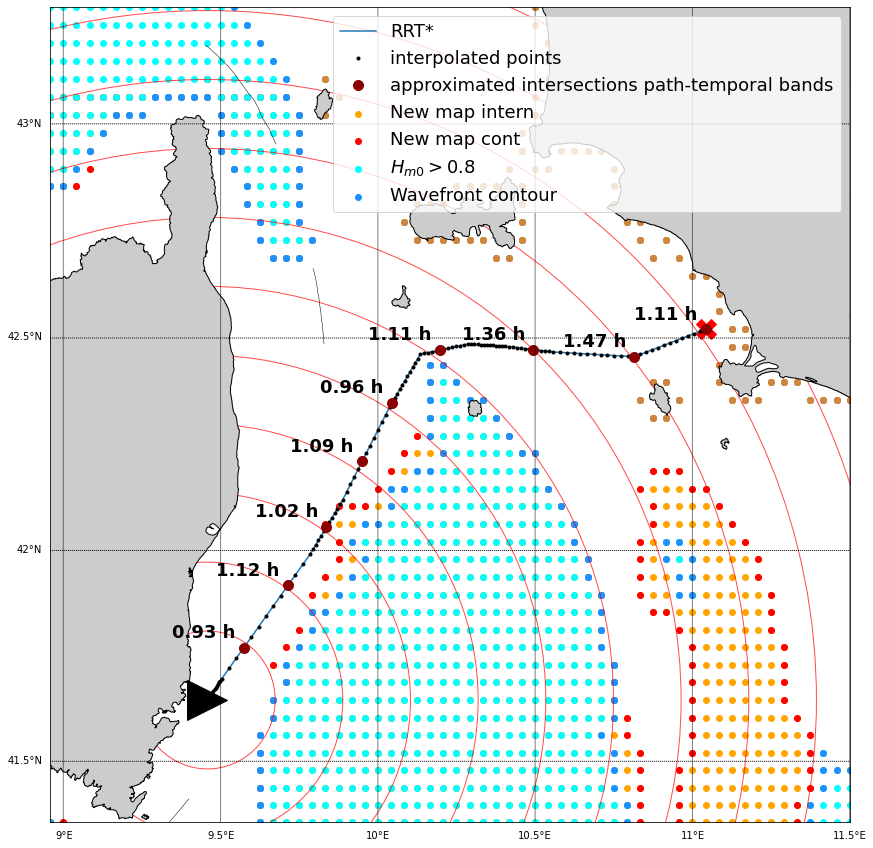

In [745]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.plot(sx_init, sy_init, ">k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
k=0
# mp2.pcolor(x, y, cost[k], cmap=ListedColormap(['white', 'red']))

for i in range(len(local_x)):
    if i == 0: 
        plt.scatter(local_x_[i], local_y_[i], color="orange",  label='New map intern') 
    else:
        plt.scatter(local_x_[i], local_y_[i], color="orange") 
plt.scatter(localcont_x_, localcont_y_, color="red", label='New map cont')
plt.scatter(x_obsl_, y_obsl_, color="peru")
plt.scatter(intern_x_, intern_y_, color="aqua", label='$H_{m0}>0.8$') 
plt.scatter(contint_x_, contint_y_, color="dodgerblue", label='Wavefront contour')
# for j in range(len(ellipse_interp)):
#     plt.plot([x for (x, y) in ellipse_interp[j]], [y for (x, y) in ellipse_interp[j]], '.', color="orange", alpha=0.5)
# for i in range(len(obstacle_list_[0])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list_[0][i][0], obstacle_list_[0][i][1]), radius=4000,
#                             color='b', alpha=0.3))
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.7, fill = False))
    
plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-',label='RRT*')
plt.plot([x for (x, y) in rrt_interp], [y for (x, y) in rrt_interp], '.k',label='interpolated points')

for i in range(len(rx_rrt_finale)):
    if i == 0:
        plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20, label='approximated intersections path-temporal bands')
    else:
        plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20)
for i in range(len(rx_rrt_finale)+1):
    if i == len(rx_rrt_finale):
        pass
#         plt.text(gx_a+2000, gy_a+5000, str(round(path_dist[i]/18,2)) + " h",fontsize=11,fontweight='bold',
#                         ha='right',va='bottom',color='k')
    else:
        plt.text(rx_rrt_finale[i]-3000, ry_rrt_finale[i]+2000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold',
                            ha='right',va='bottom',color='k')

ax.legend(prop={"size":18}, loc="upper right")
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.show()

In [746]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 15))
# plt.plot(sx_init, sy_init, ">k", markersize=10)
# plt.plot(gx_a, gy_a, "Xr", markersize=10)
# for i in range(len(obstacle_list_[0])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list_[0][i][0], obstacle_list_[0][i][1]), radius=4000,
#                             color='b', alpha=0.3))
# plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# plt.plot([x for (x, y) in rrt_interp], [y for (x, y) in rrt_interp], '.r',label='RRT*')
# plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-',label='RRT*')
# plt.plot(map_x_, map_y_, '.', color="dodgerblue")
# # plt.plot(map_x_2, map_y_2, '.', color="sienna")
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
#                                 color='red', alpha=0.7, fill = False))
# mp.fillcontinents()
# mp.drawcoastlines()
# mp.drawstates()
# mp.drawcountries()
# # plt.savefig("provarrt.png", dpi=500)
# plt.show()

# Final iterative algorithm

In [747]:
data = xr.open_dataset('wave2021.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]
# 2021-07-18, 2021-08-23, 2021-08-24, 2021-09-10, 2021-09-18, 
# 2021-10-11, 2021-10-22, 2021-10-27, 2021-10-31, 2021-11-05, 2021-12-18, 2021-03-07
july18 = data.sel(time='2021-09-10') 
wave = july18.variables['VHM0'][:]

In [ ]:
mp2 = Basemap(projection='merc',
             llcrnrlon=lons.values[0],  
             llcrnrlat=lats.values[0], 
             urcrnrlon=lons.values[-1], 
             urcrnrlat=lats.values[-1],  
             resolution='f') # f

lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp2(lon, lat)

hh = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[0],lats.values[-1]))).m / mp2(lons.values[-1],lats.values[-1])[1])
ww = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[-1],lats.values[0]))).m / mp2(lons.values[-1],lats.values[-1])[0])

print(hh, ww)

In [ ]:
l = 24
li = 3   # 0   4(7-5)  4   3   2  -  5   11    0    0    3    6    3   
le = 17  # 15  18    18  17    15  - 17   23   12   12   15   18   15   
cost = np.zeros_like(wave[li:le])
contour_raw_meteo = np.zeros_like(wave[li:le])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(le-li):
    cost[i] = 100 * (np.array(wave[i+li]) > 0.8)
    contour_raw_meteo[i]=np.logical_xor(cost[i],binary_erosion(cost[i]))

In [ ]:
xspace = lons.values
yspace = lats.values

sx = xspace[12]  
sy = yspace[7] 
gx = xspace[50]   # 39
gy = yspace[28]   # 33
sx_init, sy_init = mp2(sx, sy)
gx_a, gy_a = mp2(gx, gy)

In [759]:
# INITIAL LOCAL
intern_x, intern_y = [[] for i in range(le-li)], [[] for i in range(le-li)] 
intern_x_, intern_y_ = [[] for i in range(le-li)], [[] for i in range(le-li)] 
contint_x, contint_y = [], []  
contint_x_, contint_x_ = [], [] 
x_obsl, y_obsl = [], []
Cspacex, Cspacey = [], []
image = np.zeros((47, 62))

for i in range(le-li):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if cost[i][k][j] == 100:
                geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(xspace[12],yspace[7]))).km
                if 18*(i) < geo_dist < 18*(i+1):
                    intern_x[i].append(lons.values[j])
                    intern_y[i].append(lats.values[k]) 
                    image[k][j] = 1
    intern_x_[i], intern_y_[i] = mp2(intern_x[i], intern_y[i]) 

astar_contour = np.logical_xor(image,binary_erosion(image)) 
for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if astar_contour[k][j]:
                contint_x.append(lons.values[j])
                contint_y.append(lats.values[k]) 
contint_x_, contint_y_ = mp2(contint_x, contint_y)       # map contour points  


for k in np.arange(0,380,1):
    for j in np.arange(0,1307,1):
        if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
            if contour_raw_land[k][j]: 
                if lons_mask.values[j] > 9.8:
                    x_obsl.append(lons_mask.values[j])
                    y_obsl.append(lats_mask.values[k])
            if mask.values[k][j] == 1:
                Cspacex.append(lons_mask.values[j])
                Cspacey.append(lats_mask.values[k])                    
Cspacex_, Cspacey_ = mp2(Cspacex, Cspacey)                   
x_obsl_, y_obsl_ = mp2(x_obsl, y_obsl) 

In [773]:
# THINGS BEFORE STARTING THE ALGORITHM
# start by defining the ellipses or temporal bands
path = [[] for i in range(le-li)]
ellipseii = [[] for i in range(le-li)]
vertices = [[] for i in range(le-li)]
for i in range(le-li):
    ellipseii[i] = pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1), color='red', alpha=0.7, fill = False)
    ax.add_patch(ellipseii[i])
    path[i] = ellipseii[i].get_path()
    vertices[i] = path[i].vertices.copy()
    vertices[i] = ellipseii[i].get_patch_transform().transform(vertices[i])

xsss = [[] for i in range(le-li)]
ysss = [[] for i in range(le-li)]
for j in range(len(vertices)):
    for i in range(len(vertices[j])):
        xsss[j].append(vertices[j][i][0])
        ysss[j].append(vertices[j][i][1])

ellipse_interp = [[] for i in range(le-li)]
iii = 0
for i in range(len(vertices)):
    ellipse_interp[i] = sampling(2*(i+1), vertices[i])

## Start optimization algorithm

In [777]:
xspace = lons.values
yspace = lats.values

sx = xspace[12]  
sy = yspace[7] 
gx = xspace[50]   # 39
gy = yspace[28]   # 33
sx_init, sy_init = mp2(sx, sy)
gx_a, gy_a = mp2(gx, gy)

grid_size = 4500

obstacle_list_ = [[] for i in range(2)]
for i in range(2): # just not to modify the algorithm of RRT*
    for j, _ in enumerate(contint_x_):
        obstacle_list_[i].append([contint_x_[j], contint_y_[j], grid_size])
    for j, _ in enumerate(x_obsl_):
        obstacle_list_[i].append([x_obsl_[j], y_obsl_[j], grid_size])   

Found path!!
Travel time =  10.1698 hours


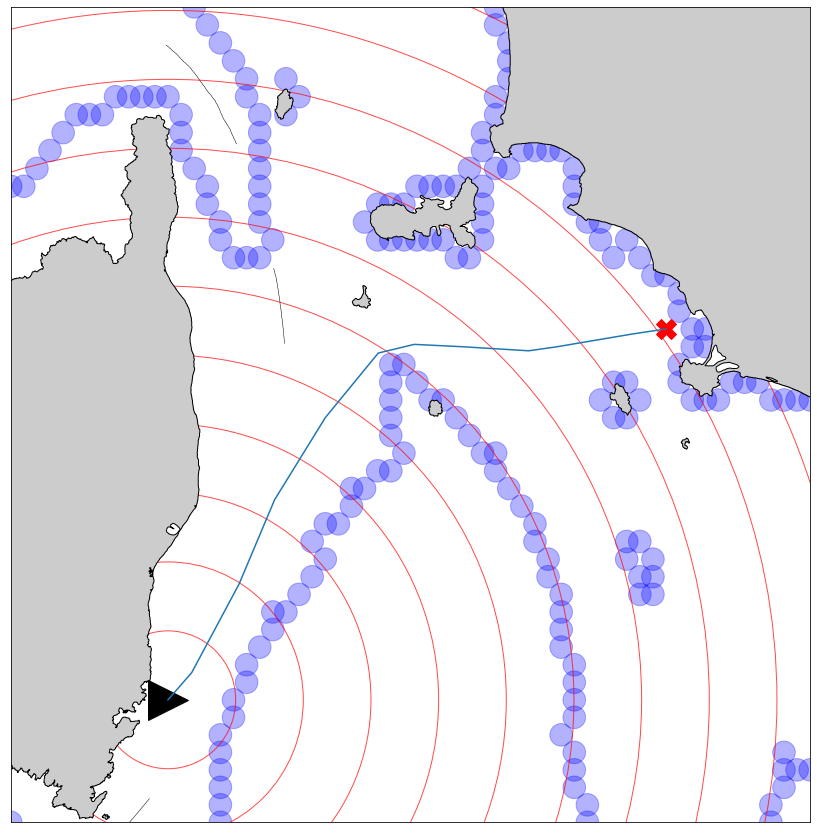

band 0
Travel time =  1.02 hours
band 1
Travel time =  1.09 hours
band 2
Travel time =  1.11 hours
band 3
Travel time =  0.93 hours
band 4
Travel time =  0.99 hours
band 5
Travel time =  1.12 hours
band 6
Travel time =  1.4 hours
band 7
Travel time =  1.26 hours
band 8
Travel time =  1.25 hours
band 9
Travel time =  0.0 hours


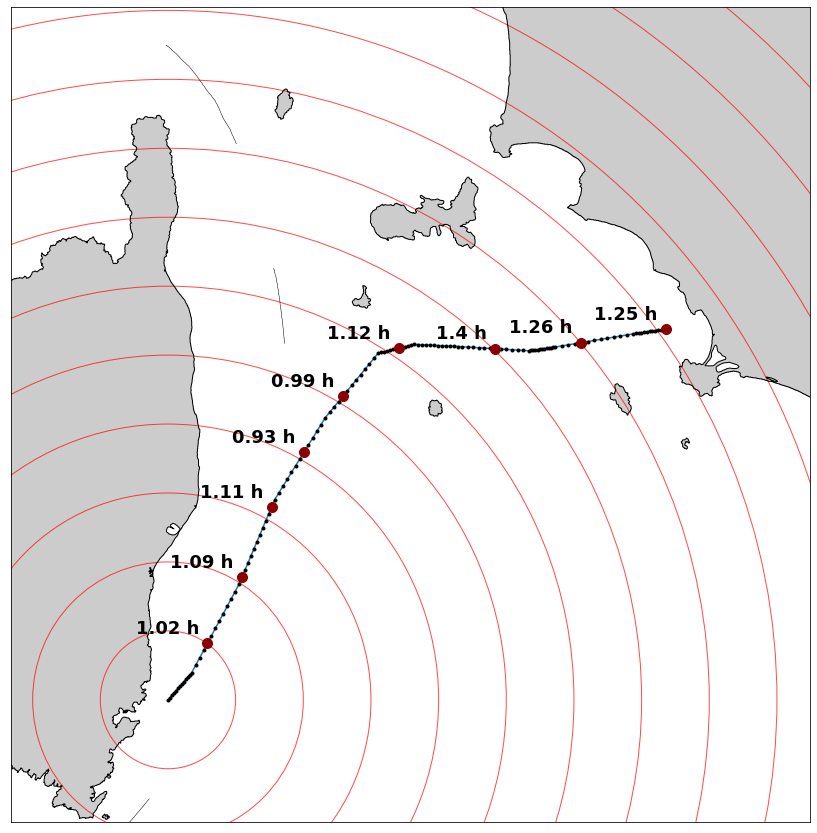

The computational time is 26.97 seconds


In [778]:
alg_start_time = time.time()
rrt_star = RRTStar(
            start=[sx_init, sy_init],
            goal=[gx_a, gy_a],
            rand_area=[x_min, x_max, y_min, y_max],
            obstacle_list=obstacle_list_,
            c_spacex = Cspacex_,
            c_spacey = Cspacey_,
            k = 1,
            speed = 5,
            path_resolution=4500.0,
            connect_circle_dist=150000,
            goal_sample_rate=15,
            expand_dis=4500)

path_star, cost_tot, iter_tot = rrt_star.planning(animation=show_animation)
path_star = list(reversed(path_star))
end_time = time.time()
if path_star is None:
    print("Cannot find path")
else:
    print("Found path!!")

p = np.zeros_like(path_star)
for i in range(len(path_star)):
    p[i][0], p[i][1]  = mp2(path_star[i][0], path_star[i][1], inverse=True)

path_dist = 0
for i in range(len(p)-1):
    path_dist += distance(lonlat(*(p[i][0],p[i][1])), 
                          lonlat(*(p[i+1][0],p[i+1][1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

## SEE HOW THE FIRST PATH IS
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.plot(sx_init, sy_init, ">k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
for i in range(len(obstacle_list_[0])):
    ax.add_patch(plt.Circle(xy=(obstacle_list_[0][i][0], obstacle_list_[0][i][1]), radius=4000,
                            color='b', alpha=0.3))
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.7, fill = False))
plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-',label='RRT*')
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.show()

## STEP 1 run the path planning algorithm
## STEP 2 sampling the path 
rrt_interp = sampling(12, path_star)   # interpolated path
p_interp = np.zeros_like(rrt_interp)  
for i in range(len(rrt_interp)):
    p_interp[i][0], p_interp[i][1]  = mp2(rrt_interp[i][0], rrt_interp[i][1], inverse=True)  ## geo coords of interpolated path
    
# find the intersection
rx_rrt = [0 for i in range(len(ellipse_interp))]  # list of intersections
ry_rrt = [0 for i in range(len(ellipse_interp))]
list_of_intersection = [[] for i in range(len(ellipse_interp))]
for i in range(len(ellipse_interp)):
    for j in range(len(rrt_interp)):
        for k in range(len(ellipse_interp[i])):
            if ellipse_interp[i][k][0] >= sx_init:
                if np.allclose([rrt_interp[j][0],rrt_interp[j][1]], 
                               [ellipse_interp[i][k][0], ellipse_interp[i][k][1]], atol=0.0001, rtol=0.027): # tune parameters 0.02058
                    rx_rrt[i] = rrt_interp[j][0]
                    ry_rrt[i] = rrt_interp[j][1]
                    list_of_intersection[i].append([rrt_interp[j][0], rrt_interp[j][1]])
    if rx_rrt[i] == 0:
        break                                   

median = []
for i in range(len(list_of_intersection)):
    if len(list_of_intersection[i]) != 0:
        median.append(list_of_intersection[i][int(np.floor(len(list_of_intersection[i])/2))])
    else:
        median.append(0)
    
rx_rrt_finale = [i[0] for i in median if i != 0]
ry_rrt_finale = [i[1] for i in median if i != 0]

path_dist = [0 for i in range(len(ellipse_interp))]
for j in range(len(ry_rrt_finale)+1):
    if j == 0: # Start from starting point to the first intersection
        for i in range(rrt_interp.index([median[j][0], median[j][1]])):
            path_dist[j] += distance(lonlat(*(p_interp[i][0],p_interp[i][1])), 
                                     lonlat(*(p_interp[i+1][0],p_interp[i+1][1]))).km
    else: 
        if j == len(rx_rrt_finale): # I go from the last intersection to the goal
            for i in range(rrt_interp.index([rx_rrt_finale[j-1], ry_rrt_finale[j-1]]), len(rrt_interp)-1):  
                path_dist[j] += distance(lonlat(*(p_interp[i][0],p_interp[i][1])),
                                         lonlat(*(p_interp[i+1][0],p_interp[i+1][1]))).km
        else:
            for i in range(rrt_interp.index([median[j-1][0], median[j-1][1]]), 
                           rrt_interp.index([median[j][0], median[j][1]])):
                path_dist[j] += distance(lonlat(*(p_interp[i][0],p_interp[i][1])),
                                         lonlat(*(p_interp[i+1][0],p_interp[i+1][1]))).km
            
    
    print(f"band {j}")
    print("Travel time = ", str(round(path_dist[j]/18,2)), "hours")

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.7, fill = False))
plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-',label='RRT*')
plt.plot([x for (x, y) in rrt_interp], [y for (x, y) in rrt_interp], '.k',label='interpolated points')
for i in range(len(rx_rrt_finale)):
    if i == 0:
        plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20, label='approximated intersections path-temporal bands')
    else:
        plt.plot(rx_rrt_finale[i], ry_rrt_finale[i], '.', color="darkred", markersize=20)
for i in range(len(rx_rrt_finale)+1):
    if i == len(rx_rrt_finale):
        pass
#         plt.text(gx_a+2000, gy_a+5000, str(round(path_dist[i]/18,2)) + " h",fontsize=11,fontweight='bold',
#                         ha='right',va='bottom',color='k')
    else:
        plt.text(rx_rrt_finale[i]-3000, ry_rrt_finale[i]+2000, str(round(path_dist[i]/18,2)) + " h",fontsize=18,fontweight='bold',
                            ha='right',va='bottom',color='k')
plt.show()    
# I have found the intersections and the path lengths
# now I have to modify the temporal bands
## STEP 3 add the maps to the temporal bands
local_x = [[] for i in range(le-li)]
local_y = [[] for i in range(le-li)]
local_x_ = [[] for i in range(le-li)]
local_y_ = [[] for i in range(le-li)]
localcont_x = []
localcont_y = []
start_time = time.time()
map_diff = 0
image = np.zeros((47, 62))

for i in range(len(rx_rrt_finale)):
    map_diff = int(np.ceil(path_until_map[i] - 1*(i+1)))
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(xspace[12],yspace[7]))).km   # compute geodetic distance from start
            if 18*(i) < geo_dist < 18*(i+1):      # if distance ranging in the temporal band 
                costsum = 0
                for r in range(i,i+map_diff+1):  # sum a precise number of maps starting from map i
                    costsum += cost[r]
                costsum = 100*(np.array(costsum)>=100)
                if costsum[k][j]:
                    image[k][j]=1
                    local_x[i].append(lons.values[j])
                    local_y[i].append(lats.values[k]) 
    local_x_[i], local_y_[i] = mp2(local_x[i], local_y[i]) 

## STEP 4 create the contour
rrt_contour = np.logical_xor(image,binary_erosion(image)) 
for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if rrt_contour[k][j]:
                localcont_x.append(lons.values[j])
                localcont_y.append(lats.values[k]) 
localcont_x_, localcont_y_ = mp2(localcont_x, localcont_y)  

grid_size = 4500
obstacle_list_ = [[] for i in range(2)]
for i in range(2): # just not to modify the algorithm of RRT*
    for j, _ in enumerate(localcont_x_):
        obstacle_list_[i].append([localcont_x_[j], localcont_x_[j], grid_size])
    for j, _ in enumerate(x_obsl_):
        obstacle_list_[i].append([x_obsl_[j], y_obsl_[j], grid_size])   
print("The computational time is " + str(round(time.time() - alg_start_time, 2)) + " seconds") 

## Let's move on to compute travel time for each band

In [257]:
mp2 = Basemap(projection='merc',
             llcrnrlon=lons.values[0],  
             llcrnrlat=lats.values[0], 
             urcrnrlon=lons.values[-1], 
             urcrnrlat=lats.values[-1],  
             resolution='f') # f

lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp2(lon, lat)

x_min, y_min = mp2(lons.values[0], lats.values[0]) 
x_max, y_max = mp2(lons.values[-1], lats.values[-1])

hh = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[0],lats.values[-1]))).m / mp2(lons.values[-1],lats.values[-1])[1])
ww = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[-1],lats.values[0]))).m / mp2(lons.values[-1],lats.values[-1])[0])

print(hh, ww)

24369.62094343742 23918.5304863459


In [693]:
map_x_3, map_y_3 = mp2(map_x, map_y)              
map_x_23, map_y_23 = mp2(map_x2, map_y2) 

xspace = lons.values
yspace = lats.values

sx = xspace[12]  
sy = yspace[7] 
gx = xspace[50]   # [29]  39
gy = yspace[28]   # [37]  33
sx_init, sy_init = mp2(sx, sy)
gx_a, gy_a = mp2(gx, gy)

rx_2, ry_2 = mp2(rx, ry)
astar_interp__2 = []
for i in range(len(astar_interp)):
    temp1, temp2 = mp2(astar_interp[i][0], astar_interp[i][1])
    astar_interp__2.append([temp1, temp2])
    
    
# for i in range(len(rx_)):
#     for j in range(len(x1)):
#         if np.allclose([rx_[i],ry_[i]], [x1[j], x2[j]], atol=0.05, rtol=0.04):
#             rx_star = rx_[i]
#             ry_star = ry_[i]
#             print(True)

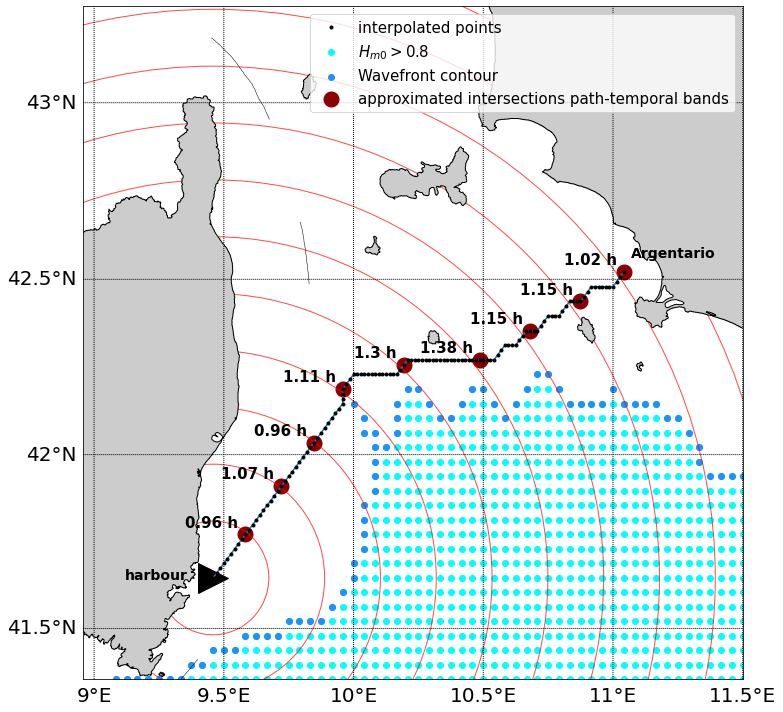

In [751]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
mp2.plot(sx_init, sy_init, ">k", markersize=30)
# mp2.plot(gx_a, gy_a, "Xr", markersize=20)
plt.text(sx_init-11000, sy_init-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(gx_a+3000, gy_a+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
path = [[] for i in range(le-li)]
ellipseii = [[] for i in range(le-li)]
vertices = [[] for i in range(le-li)]
for i in range(le-li):
    ellipseii[i] = pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),color='red', alpha=0.7, fill = False)
    ax.add_patch(ellipseii[i])
    path[i] = ellipseii[i].get_path()
    vertices[i] = path[i].vertices.copy()
    vertices[i] = ellipseii[i].get_patch_transform().transform(vertices[i])

xsss = [[] for i in range(le-li)]
ysss = [[] for i in range(le-li)]
for j in range(len(vertices)):
    for i in range(len(vertices[j])):
        xsss[j].append(vertices[j][i][0])
        ysss[j].append(vertices[j][i][1])
    
plt.scatter(map_x_3, map_y_3, color="aqua", label='$H_{m0}>0.8$')  # improved sum
plt.scatter(map_x_23, map_y_23, color="dodgerblue", label='Wavefront contour')
mp2.plot(rx_2, ry_2, '-')
# for j in range(len(vertices)):
#     mp2.plot(xsss[j], ysss[j], '.k')
plt.plot([x for (x, y) in astar_interp__2], [y for (x, y) in astar_interp__2], '.k',label='interpolated points')
# for j in range(len(ellipse_interp)):
#     plt.plot([x for (x, y) in ellipse_interp[j]], [y for (x, y) in ellipse_interp[j]], '.y')
# plt.plot([x for (x, y) in ellipse_interp[0]], [y for (x, y) in ellipse_interp[0]], '.b', markersize=5)

for i in range(len(rx_star_finale)):
    if i == 0:
        plt.scatter(rx_star_finale[i], ry_star_finale[i], color="darkred", linewidth=10, label='approximated intersections path-temporal bands')
    else:
        plt.scatter(rx_star_finale[i], ry_star_finale[i], color="darkred", linewidth=10)
# mp.plot(rx_[:rx_.index(rx_star)+1], ry_[:rx_.index(rx_star)+1], '-b')
#mp.plot(loaded_list[3], loaded_list2[3], '-b')

for i in range(len(rx_star_finale)+1):
    if i == len(rx_star_finale):
        pass
#         plt.text(gx_a+2000, gy_a+5000, str(round(path_dist[i]/18,2)) + " h",fontsize=11,fontweight='bold',
#                         ha='right',va='bottom',color='k')
    else:
        plt.text(rx_star_finale[i]-3000, ry_star_finale[i]+2000, str(round(path_dist[i]/18,2)) + " h",fontsize=15,fontweight='bold',
                            ha='right',va='bottom',color='k')
ax.legend(prop={"size":15}, loc="upper right")
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1], fontsize=20) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0], fontsize=20) #latitudes
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
mp2.fillcontinents()
plt.savefig("improvedsumv2step2_1xema.png", dpi=300, bbox_inches='tight')
plt.show()